## Prepare HotpotQA dataset

In [2]:
import pandas as pd
import re

In [7]:
# splits = {'train': 'question-answer-passages/train-00000-of-00001.parquet', 'test': 'question-answer-passages/test-00000-of-00001.parquet'}
# df_biosask = pd.read_parquet("hf://datasets/enelpol/rag-mini-bioasq/" + splits["train"])

# df1 = pd.read_parquet("hf://datasets/enelpol/rag-mini-bioasq/text-corpus/test-00000-of-00001.parquet")

# df1.head().loc[0].passage

# df_biosask.head()

In [62]:

text = "Title: First section Title: Second section Title: Third section"

# Split but keep 'Title: ' at the start of each chunk
parts = re.split(r'(Title: )', text)
parts

['',
 'Title: ',
 'First section ',
 'Title: ',
 'Second section ',
 'Title: ',
 'Third section']

In [ ]:
df = pd.read_parquet("hotpotQA.parquet")
df.drop(columns = ["citations", "answer"], inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'hotpotQA.parquet'

In [ ]:
df['new_context'] = df['context'].apply(lambda x: x.split('\nPassage:')) # need to split on title no choice
test = df['new_context'].loc[0]

j = 0
for elem in test: 
    if "Title:" in elem: 
        j+=1
# new_test = []
# for i in range(0, len(test)-1, 2): 
#     new_test.append( test[i] +  test[i+1])

# new_test


In [47]:
df = pd.read_parquet("hotpotQA.parquet")

df["citation_size"] = df["citations"].apply(lambda x: len(x))

def extract_titles(text) : 
    return re.findall(r"Title:\s*(.*?)\nPassage:", text)

df["context_citations"] = df["context"].apply(lambda x: extract_titles(x))

def flag_documents(all_citations, pos_citations) : 
    flags = []
    for elem in all_citations: 
        if elem in pos_citations: 
            flags.append("P")
        else: 
            flags.append("N")
    return flags

df["documents_flag"] = df[["context_citations", "citations"]].apply(lambda x: flag_documents(x["context_citations"], x["citations"]), axis=1)

In [51]:
# df = pd.read_parquet("hotpotQA.parquet")
# df.drop(columns = ["citations", "answer"], inplace=True)

# df['context_size'] = df['context'].apply(lambda x: len([i for i in re.split(r'(Title: )', text = x) if len(i) > 1]))
df['context_size'] = df['context'].apply(lambda x: len([i for i in x.split('Title: ') if len(i) > 1]))
df_select = df[df['context_size'] == 10].sample(n = 100, random_state=42).drop(columns = ['context_size'])

df_select['true_context'] = df['context'].apply(lambda x : [ i for i in x.split('Title:') if len(i) > 1])
df_select.drop(columns = ["context"], inplace=True)
df_select.rename(columns = {'true_context' : 'context'}, inplace=True)

df_select.head()
clean_context = []
for i in df_select.index: 
    clean_context.append([i.split("\nPassage: ")[1] for i in df_select.loc[i].context]) # Remove everything befoire (and including) \nPassage: (makes it cleaner)

df_select['context'] = clean_context
df_select.reset_index(inplace=True, drop = True)
df_select.drop(["answer", "citations", "citation_size", "context_citations"], axis = 1, inplace=True)
df_select

,question,documents_flag,context
0,"""Girls Girls"", was released by Atlantic Record...","[P, N, N, N, N, N, N, N, N, P]","[""Girls Girls"" (stylized as ""GIRLS GIRLS"") is ..."
1,What is the name of the character in Quantico ...,"[P, N, N, N, N, P, N, N, N, N]",[Russell George Tovey (born 14 November 1981) ...
2,How many MLB teams did the baseball player wh...,"[N, P, P, N, N, N, N, N, N, N]","[Mark David McGwire (born October 1, 1963), ni..."
3,Did Mala Mala or Train Life come first?,"[N, N, N, N, N, P, N, N, P, N]",[St Philip Howard Catholic Voluntary Academy (...
4,Professional racing driver Stéphane Richelmi w...,"[N, N, N, N, N, N, P, N, P, N]",[Stéphane Jean-Marc Sarrazin (born 2 November ...
...,...,...,...
95,"Between Trent Reznor and Ali Campbell, who has...","[N, N, P, N, N, N, N, N, N, P]",[12 Rounds is a British rock band formed by At...
96,What 2002 horror film was written and directed...,"[P, N, N, N, N, N, P, N, N, N]",[Phone () is a 2002 South Korean horror film w...
97,What year did a neo-noir action thriller starr...,"[N, N, N, N, N, N, P, P, N, N]",[East Longmeadow High School is a public high ...
98,What founder of a trademarked brand name for a...,"[N, P, N, N, N, P, N, N, N, N]",[Ansco was the brand name of a photographic co...


In [52]:
df_select.to_csv("hotpotQA_sample_flagged.csv", index= False)

## Explore Bioask data

In [59]:
splits = {'train': 'question-answer-passages/train-00000-of-00001.parquet', 'test': 'question-answer-passages/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/enelpol/rag-mini-bioasq/" + splits["train"])

df1 = pd.read_parquet("hf://datasets/enelpol/rag-mini-bioasq/text-corpus/test-00000-of-00001.parquet")
df1.set_index('id', inplace=True)

In [ ]:
df.

,question,answer,id,relevant_passage_ids
0,What is the implication of histone lysine meth...,"Aberrant patterns of H3K4, H3K9, and H3K27 his...",1682,"[23179372, 19270706, 23184418]"
1,What is the role of STAG1/STAG2 proteins in di...,STAG1/STAG2 proteins are tumour suppressor pro...,3722,"[26997282, 21589869, 19822671, 29867216, 15361..."
2,What is the association between cell phone use...,The association between cell phone use and inc...,1235,"[20215713, 17851009, 22882019, 12527940, 24348..."
3,What is the applicability of the No Promoter L...,No Promoter Left Behind (NPLB) is an efficient...,2103,[26530723]
4,Does the Oncotype DX test work with paraffin e...,"Yes, the Oncotype DX test works with paraffin ...",1713,"[23074401, 17039265, 18922117, 17463177, 16361..."


In [ ]:
a = df_select.context[0]

10

In [87]:
df_test = pd.read_csv("hotpotQA_sample.csv")
df_test.to_parquet("hotpotQA_sample.parquet")

In [92]:
df_test = pd.read_csv("hotpotQA_sample.csv", on_bad_lines="skip")

In [66]:
df1.passage[df.relevant_passage_ids[0][:10]]

id
23179372    Recent studies showed frequent mutations in hi...
19270706    We used high-resolution SNP genotyping to iden...
23184418    Recent sequencing efforts have described the m...
Name: passage, dtype: object

In [85]:
test = ['"Girls Girls" (stylized as "GIRLS GIRLS") is a song by Swedish electropop duo Icona Pop.  It was written by Litens Anton Nilsson, Icona Pop, Marcus Andersson, Tove Lo, Emma Bertilsson and Johan Gustafson, with the latter one handling the song\'s production.  It was released commercially for digital download on 16 June 2017, through TEN Music Group, Atlantic Records and Warner Music Group, as the duo\'s first single of 2017.\n', 'Wonder World is the second studio album by South Korean pop girl group Wonder Girls.  It was released on November 7, 2011.  It was produced by Park Jin-Young.  "Be My Baby" served as the lead single from album.  Both album and single were commercial success.  Album was promoted with a "Wonder World Tour" in 2012.  Members were more involved in songwriting in production: Park Yeeun wrote and produced "G.N.O." and "Me, In", Kim Yubin wrote "Girls Girls", "Me, In" and "Sweet Dreams" while Woo Hyelim wrote and produced her solo song "Act Cool", featuring San E.  Members also recorded duets: Min Sunye and Yeeun recorded "Long Long Time" while Yubin and Ahn Sohee recorded "SuperB".\n', 'Girls Girls (Korean: 여자여자 , often stylized as GIRLS GIRLS) debuted as five-member South Korean girl group formed by H Brothers Entertainment.  They debuted on December 9, 2015, with a single-album titled "Deal".  This single-album is containing two songs - "Deal(딜)" and "GIRLS GIRLS(여자여자)".  In the middle of 2016, Gyurang left the group to focus on her solo activities.  On October 10, 2016 they released their 2nd single album called "Juicy Secret" which contains one song called "Juicy Secret(쥬시시크릿)".\n', 'Ferras Alqaisi ( ; born July 2, 1982) is an American singer-songwriter from Los Angeles, California.  He is well known for his single "Hollywood\'s Not America" from his debut album "Aliens & Rainbows", which was featured as the exit song during the semi-final round of "American Idol" season 7.  He is signed with Unsub Records, a subsidiary of Capitol Records founded by Katy Perry, being the first artist to sign with her label.  In June 2014 he released his self-titled EP through the label.\n', 'Atlantic Records UK was founded in June 2004 when Warner Music Group bought East West Records from Time Warner and rebranded its UK operation.  The first Chairman was Max Lousada, previously Head of A&R at Mushroom Records UK.  In 2011 Atlantic Records UK was named Label of the Year at the Music Week Awards.  In the same year The Guardian put Lousada joint 20th in its "Music Power 100" list of influential figures in the UK music industry.  He shared his place with John Reid and Christian Tattersfield, both from Warner.  In October 2011, the7stars advertising agency announced it had won a pitch to handle Atlantic Records UK\'s £2 million media planning and buying account, taking over from ZenithOptimedia.  In 2014, Ben Cook was appointed President, Atlantic Records UK, reporting to Lousada.\n', 'Got7, a hip hop boy group based in South Korea, have released three studio albums, six EPs, thirteen singles, and two box sets. Formed by JYP Entertainment in 2013, Got7 made their debut in January 2014 with the EP "Got It? ", which debuted at number two on the Gaon Albums Chart.  The EP\'s lead single "Girls Girls Girls" peaked at number 21 on the Gaon Singles Chart.  In October 2014, Got7 debuted in Japan with their first Japanese-language release "Around the World", peaking at number three on the Oricon\'s singles charts.  A month later, Got7 returned to Korea to release their first full-length album "Identify", and topped album charts.\n', 'Got It?  is the debut extended play by South Korean boy band Got7.  It was released on January 16, 2014.  The song "Girls Girls Girls" was used to promote the EP.\n', 'Atlantic Records Group is an umbrella label at Warner Music Group that oversee\'s the labels assigned to its Atlantic Records unit.  In total, the label has nearly three hundred artists on its roster.  As recently, Atlantic Records has made a deal in 2009 with artist Jay Z to distribute his "The Blueprint 3" album, as it\'s not only self-distributed by Atlantic Records, his music videos on YouTube are distributed and partially owned by Atlantic Records, as all of his music under the Atlantic Records contract is not played on Vevo.\n', '"(I Don\'t Want to Go to) Chelsea" is a 1978 song by Elvis Costello.  Released as a single from his album "This Year\'s Model", it reached No. 16 on the UK Singles Chart.  In his album notes for "Girls Girls Girls", Costello wrote that the song "[m]ight have been just a poor relation to \'All of the Day (and All of the Night)\', \'I Can\'t Explain\' or even \'Clash City Rockers\' had it not been for Bruce Thomas\' great bassline.  Meanwhile I was trying to fit in this lick from an old Pioneers record, though which one I can\'t recall."\n', 'Atlantic Recording Corporation (simply known as Atlantic Records) is an American major record label founded in October 1947 by Ahmet Ertegün and Herb Abramson.  Over its first 20 years of operation, Atlantic Records earned a reputation as one of the most important American recording labels, specializing in jazz, R&B and soul recordings by African-American musicians including Aretha Franklin, Ray Charles, Wilson Pickett, Sam and Dave, Ruth Brown and Otis Redding, a position greatly enhanced by its distribution deal with Stax Records.  In 1967, Atlantic Records became a wholly owned subsidiary of Warner Bros.-Seven Arts, now the Warner Music Group, and expanded into rock and pop music with releases by bands such as Led Zeppelin and Yes.']
test = f"{test}"
test.tolist()

AttributeError: 'str' object has no attribute 'tolist'

## NDCG Scoring

In [2]:
import numpy as np
from sklearn.metrics import ndcg_score

In [7]:
exact_shap_score = [ 7.28458438,  4.61024789,  1.12222367,  4.46217897,  6.01809617,                                                                                                                                    
        9.01740065, 51.42986124, -3.03477679,  3.25840788,  3.25840788]
exact_shap_score = np.clip(exact_shap_score, a_min=0, a_max=None)
wss32_score = [ 3.99569727, 14.96310279,  2.56118023,  1.7651463 ,  4.74337511,
        3.82272672, 48.92864721, -0.35338783,  4.72189731,  2.27824682]
context_cite32 = [ 3.16083134, 14.04952142,  1.7000356 ,  0.91405258,  3.75751841,
        3.00394725, 48.00304627, -1.17642462,  3.90705701,  1.30896562]

print("score with wss32: ", ndcg_score([exact_shap_score], [wss32_score]))
print("score with contextCite32: ", ndcg_score([exact_shap_score], [context_cite32]))

score with wss32:  0.9761219717376033
score with contextCite32:  0.973356488290674


### Metric : Kendall tau

In [20]:
from scipy.stats import rankdata, kendalltau

exact_shap_score = [ 7.28458438,  4.61024789,  1.12222367,  4.46217897,  6.01809617,                                                                                                                                    
        9.01740065, 51.42986124, -3.03477679,  3.25840788,  3.25840788]
wss32_score = [ 3.99569727, 14.96310279,  2.56118023,  1.7651463 ,  4.74337511,
        3.82272672, 48.92864721, -0.35338783,  4.72189731,  2.27824682]

context_cite32 = [ 3.16083134, 14.04952142,  1.7000356 ,  0.91405258,  3.75751841,
        3.00394725, 48.00304627, -1.17642462,  3.90705701,  1.30896562]

exact_ranks = rankdata([-x for x in exact_shap_score], method='average')
approx_ranks = rankdata([-x for x in context_cite32], method='average')

tau, pval = kendalltau(exact_ranks, approx_ranks)
print(f"Kendall's Tau: {tau:.4f}, p-value: {pval:.4f}")

# Kendall's Tau: 0.4495, p-value: 0.0725

Kendall's Tau: 0.4045, p-value: 0.1060


## Negative Document Identification

In [44]:
df = pd.read_parquet("hotpotQA.parquet")

df["citation_size"] = df["citations"].apply(lambda x: len(x))

def extract_titles(text) : 
    return re.findall(r"Title:\s*(.*?)\nPassage:", text)

df["context_citations"] = df["context"].apply(lambda x: extract_titles(x))

def flag_documents(all_citations, pos_citations) : 
    flags = []
    for elem in all_citations: 
        if elem in pos_citations: 
            flags.append("P")
        else: 
            flags.append("N")
    return flags

df["documents_flag"] = df[["context_citations", "citations"]].apply(lambda x: flag_documents(x["context_citations"], x["citations"]), axis=1)

In [61]:
df_test = pd.DataFrame(columns = ["Query", "Score", "Flags"])
df_test.loc[0] = ["Dag Idereen", [1,2,3], ["P", "P", "N"]]
df_test.loc[0] = ["Tot Ziens", [1,2,3], ["P", "P", "N"]]
df_test

,Query,Score,Flags
0,Tot Ziens,"[1, 2, 3]","[P, P, N]"


In [ ]:
df_select

,question,documents_flag,context
0,"""Girls Girls"", was released by Atlantic Record...","[P, N, N, N, N, N, N, N, N, P]","[""Girls Girls"" (stylized as ""GIRLS GIRLS"") is ..."
1,What is the name of the character in Quantico ...,"[P, N, N, N, N, P, N, N, N, N]",[Russell George Tovey (born 14 November 1981) ...
2,How many MLB teams did the baseball player wh...,"[N, P, P, N, N, N, N, N, N, N]","[Mark David McGwire (born October 1, 1963), ni..."
3,Did Mala Mala or Train Life come first?,"[N, N, N, N, N, P, N, N, P, N]",[St Philip Howard Catholic Voluntary Academy (...
4,Professional racing driver Stéphane Richelmi w...,"[N, N, N, N, N, N, P, N, P, N]",[Stéphane Jean-Marc Sarrazin (born 2 November ...
...,...,...,...
95,"Between Trent Reznor and Ali Campbell, who has...","[N, N, P, N, N, N, N, N, N, P]",[12 Rounds is a British rock band formed by At...
96,What 2002 horror film was written and directed...,"[P, N, N, N, N, N, P, N, N, N]",[Phone () is a 2002 South Korean horror film w...
97,What year did a neo-noir action thriller starr...,"[N, N, N, N, N, N, P, P, N, N]",[East Longmeadow High School is a public high ...
98,What founder of a trademarked brand name for a...,"[N, P, N, N, N, P, N, N, N, N]",[Ansco was the brand name of a photographic co...


## Analyse Exact Shap Results

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

In [177]:
df_shap = pd.read_json("Exact_shap_detail.json", orient="records", lines=True)
df_plot = df_shap[["scores", "doc_flags"]].copy()

### Visualisation

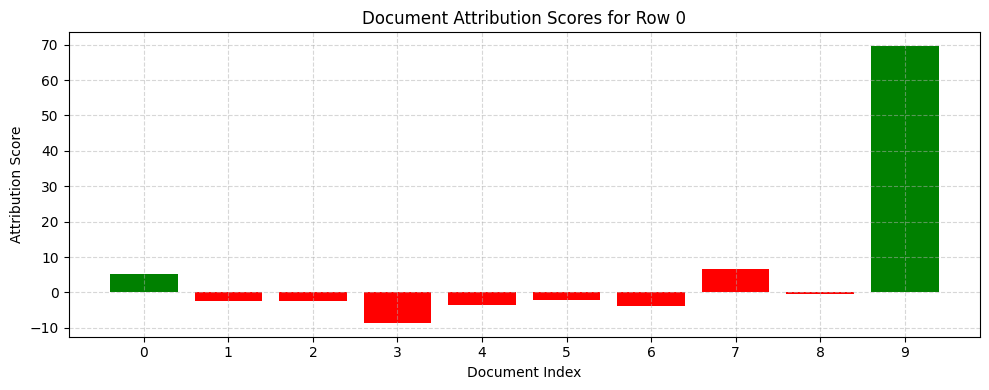

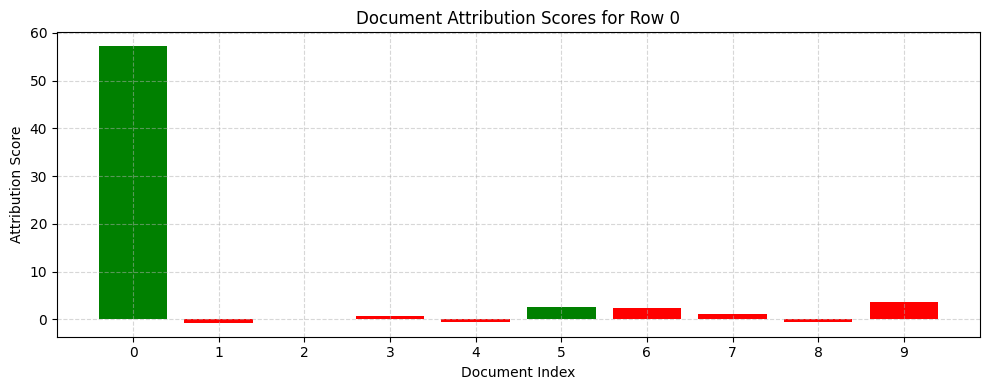

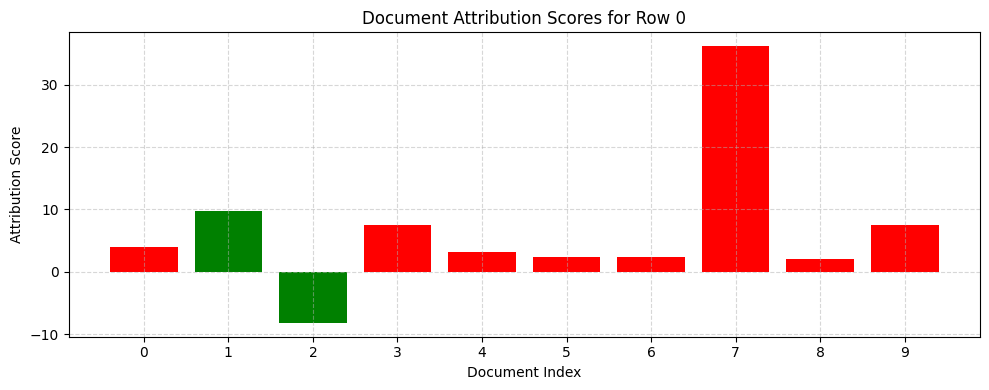

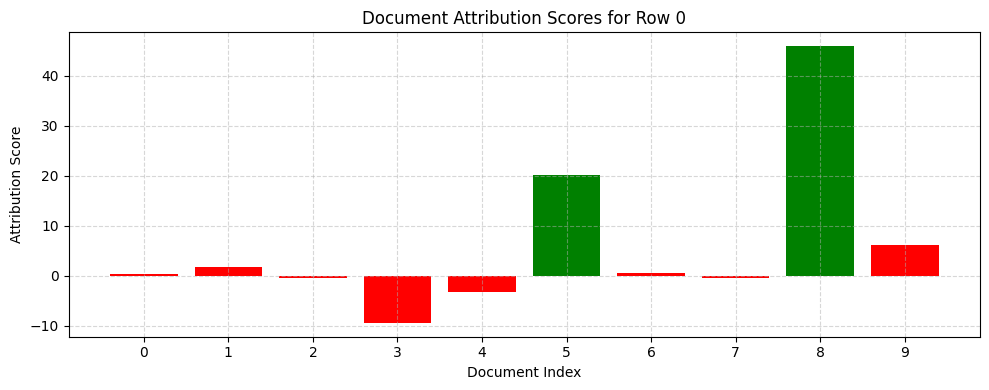

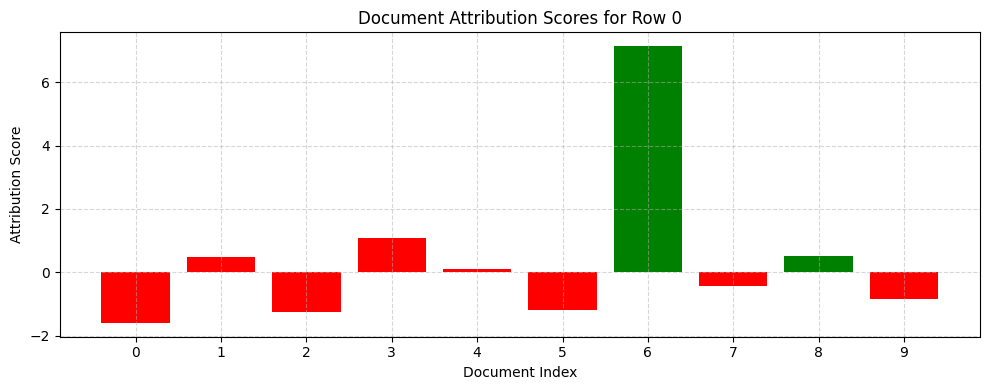

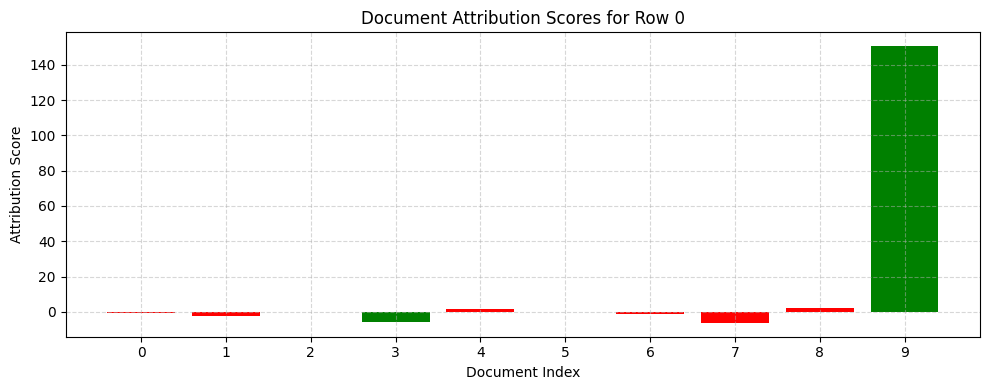

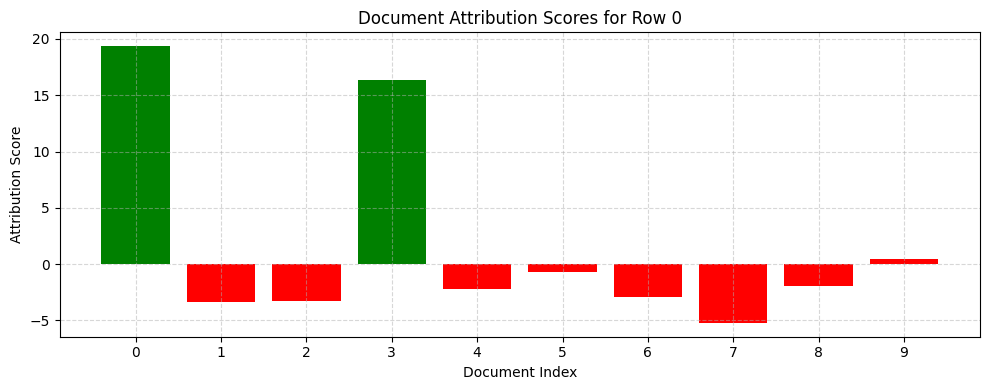

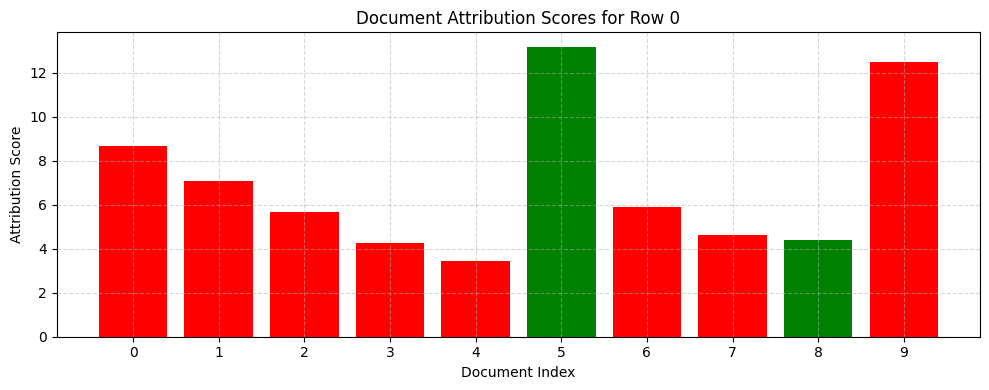

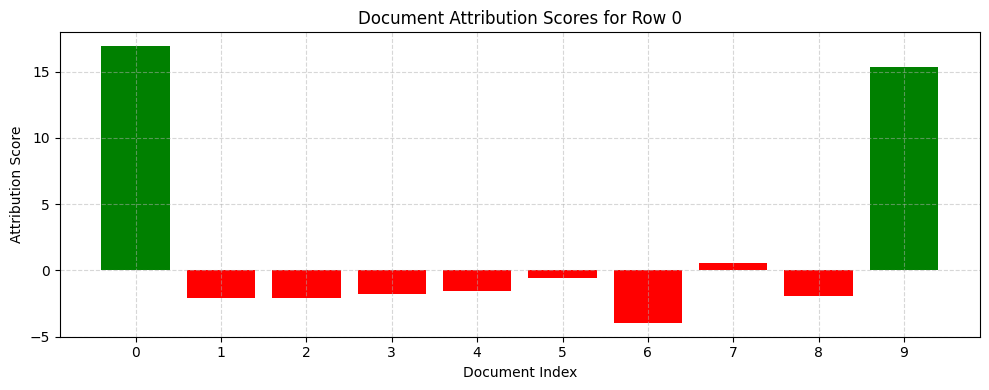

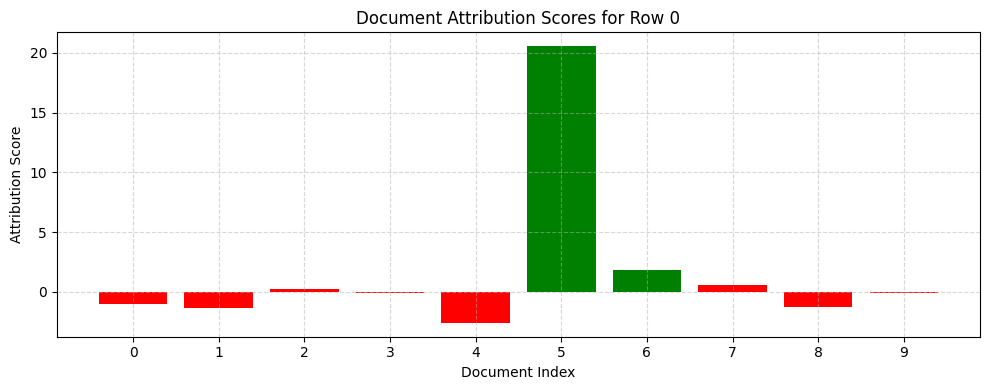

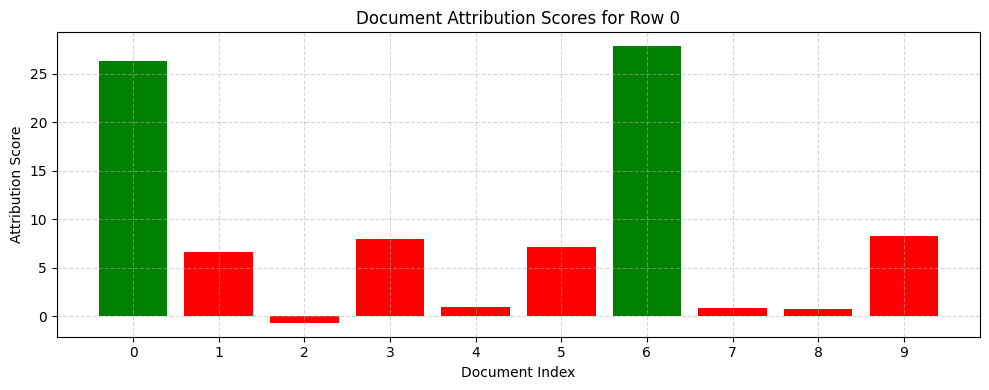

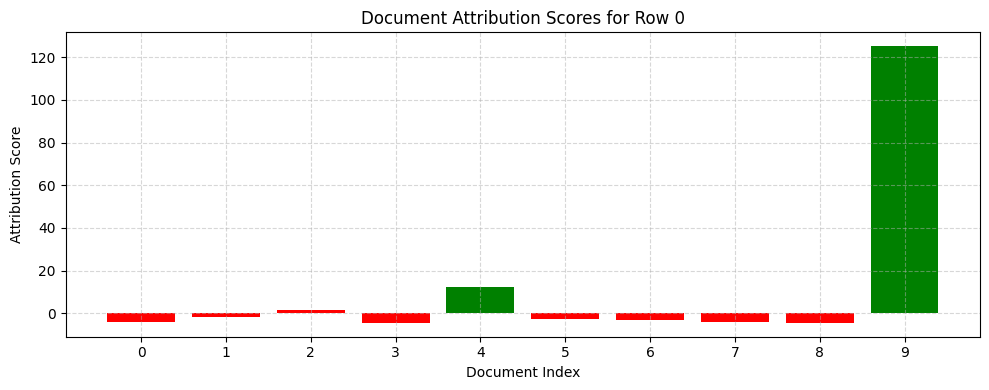

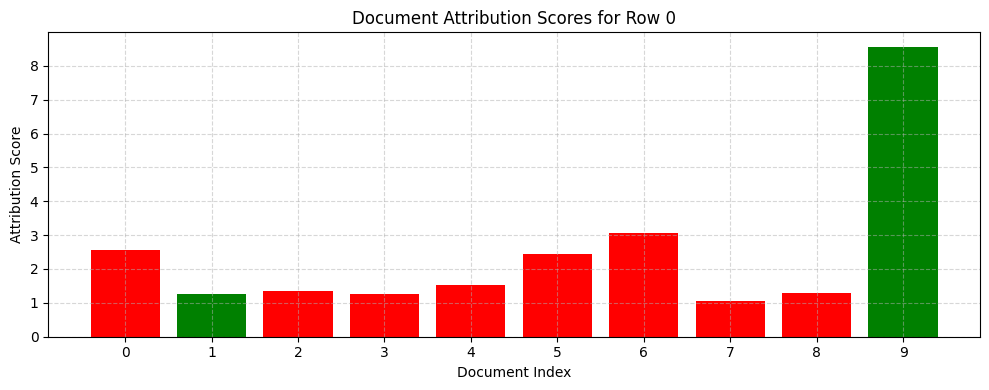

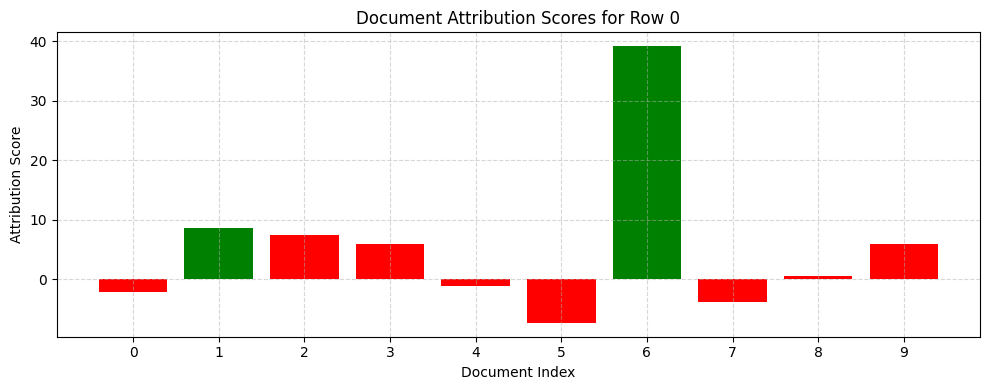

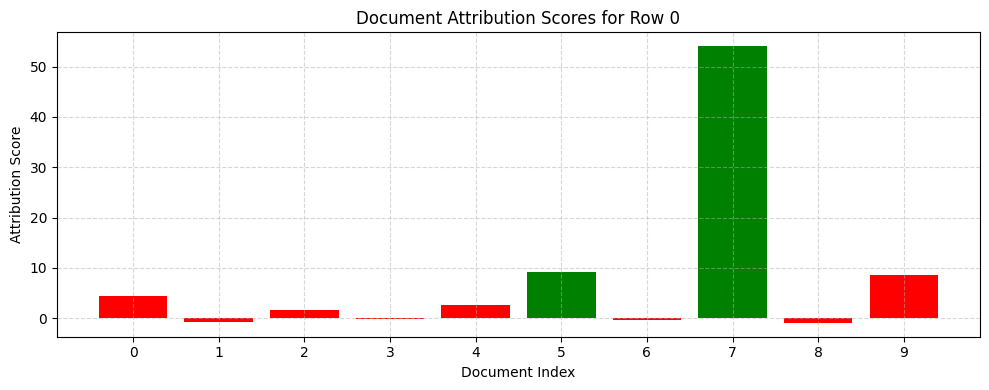

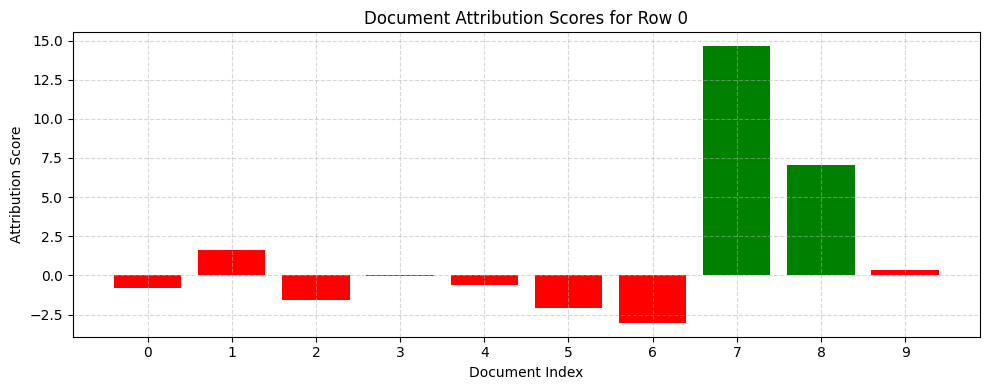

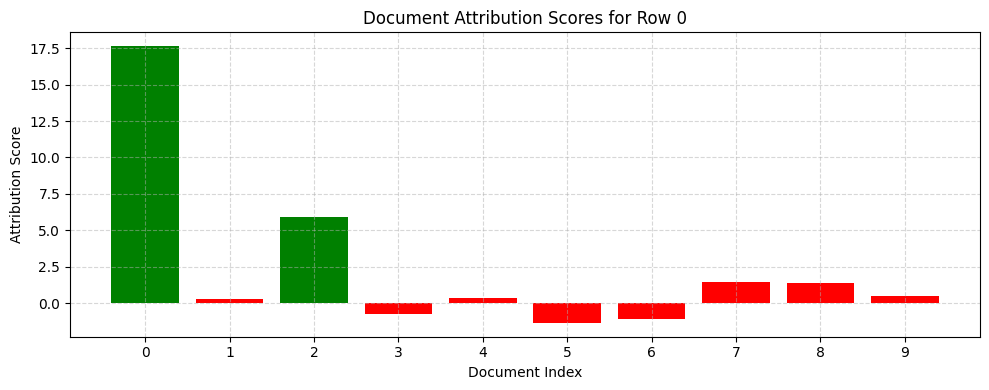

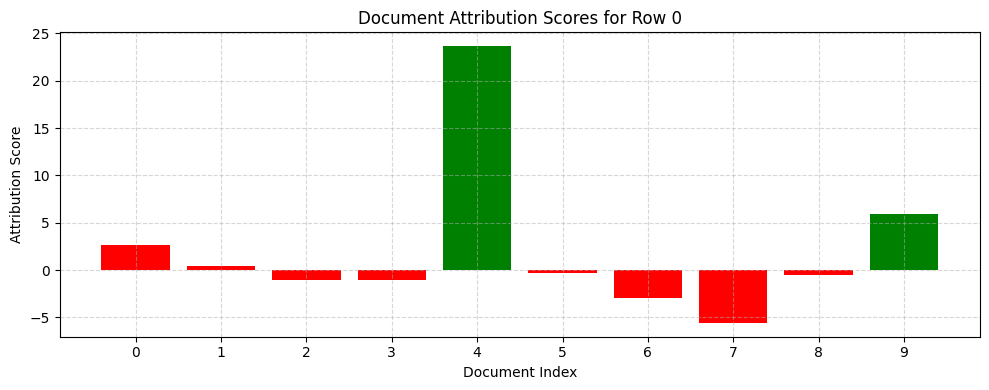

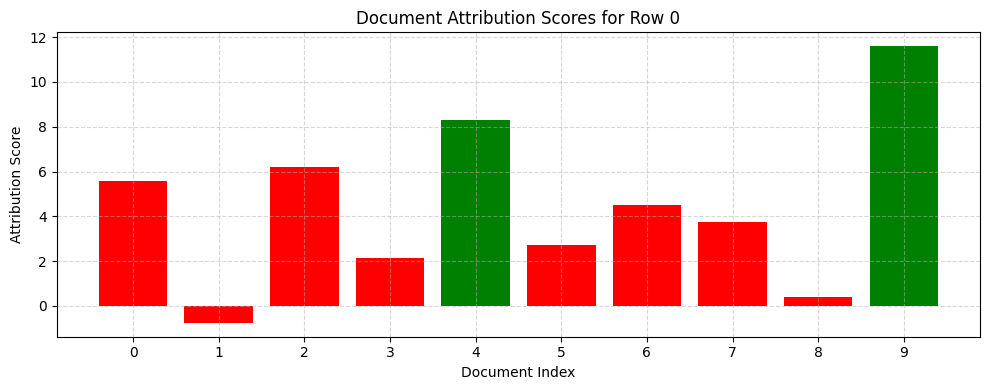

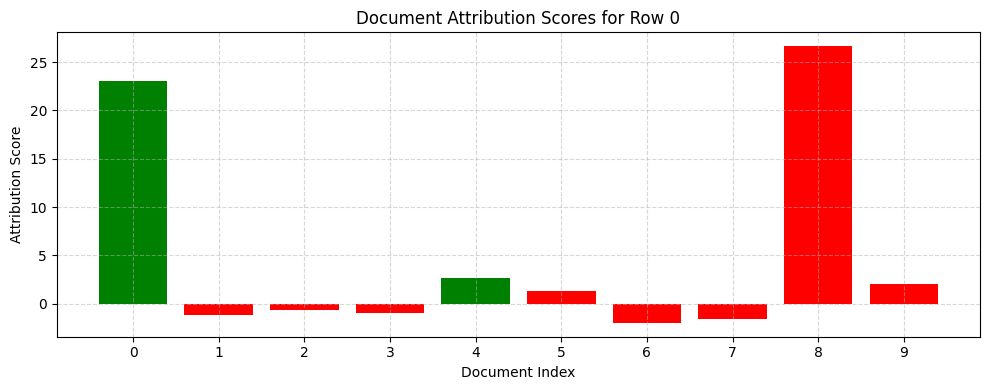

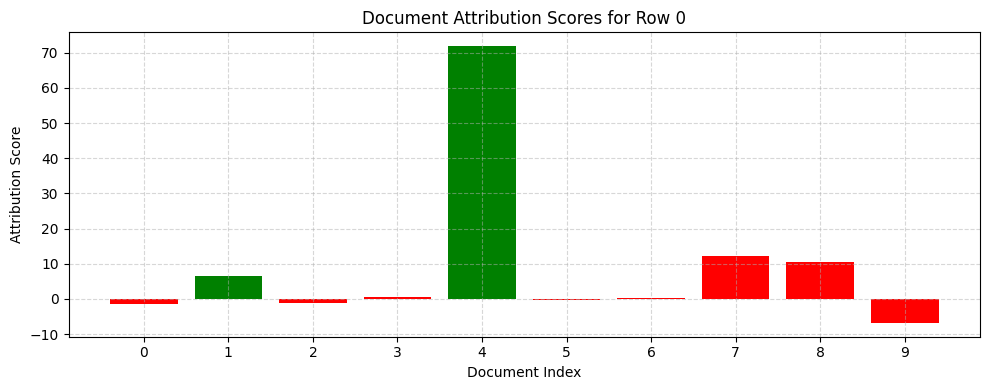

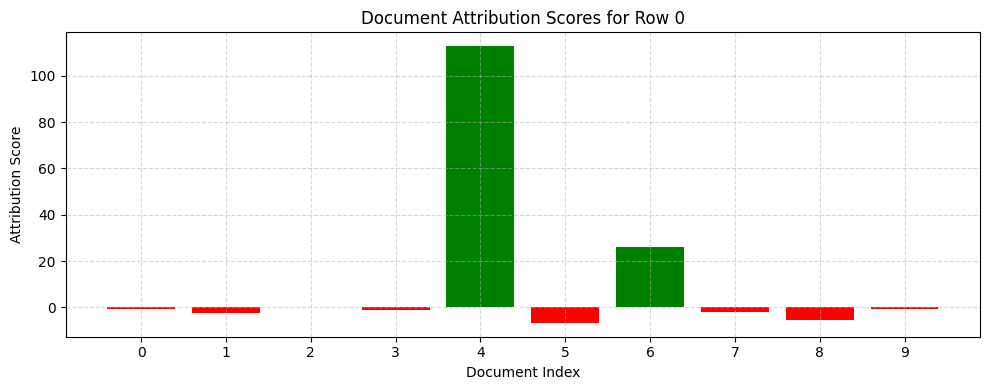

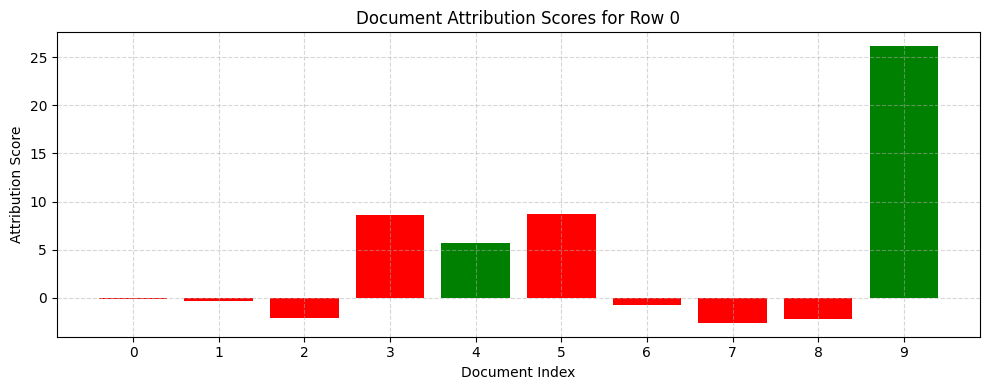

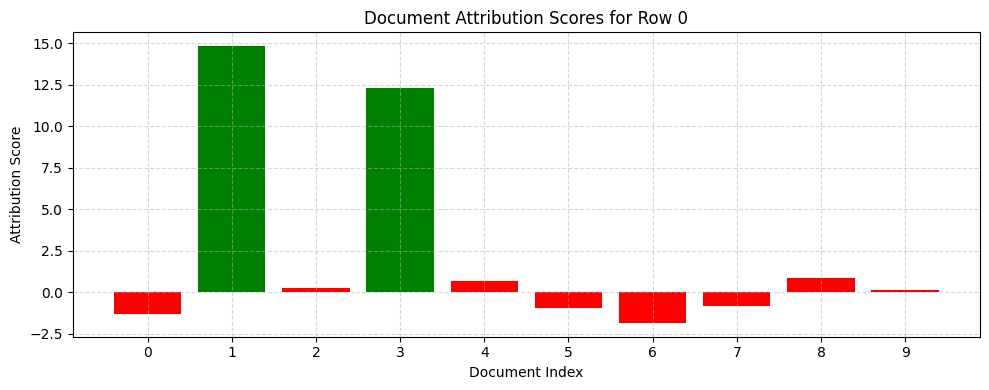

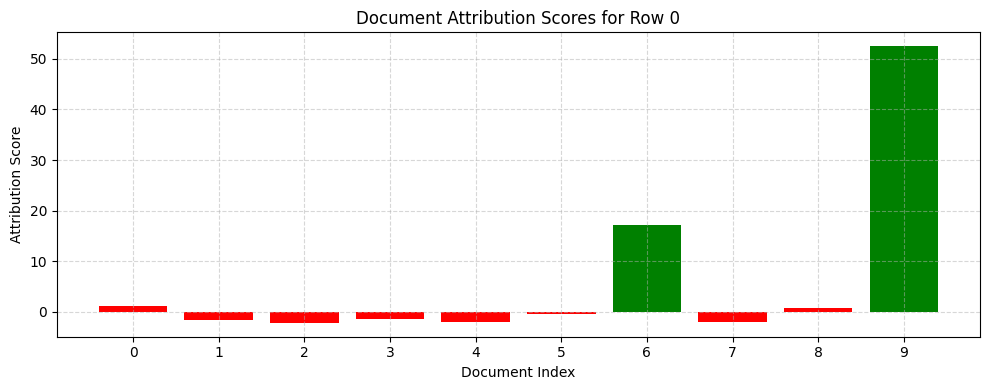

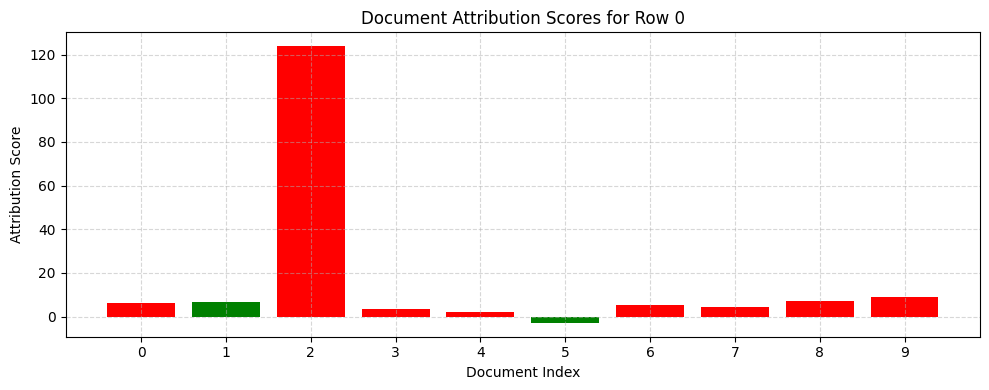

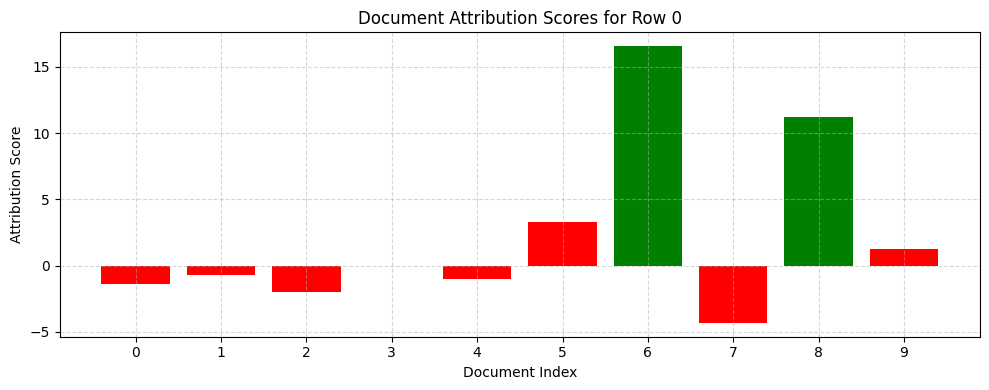

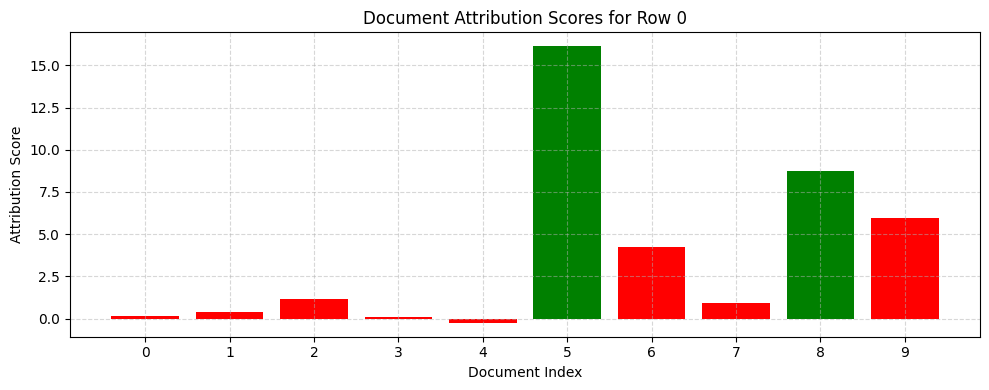

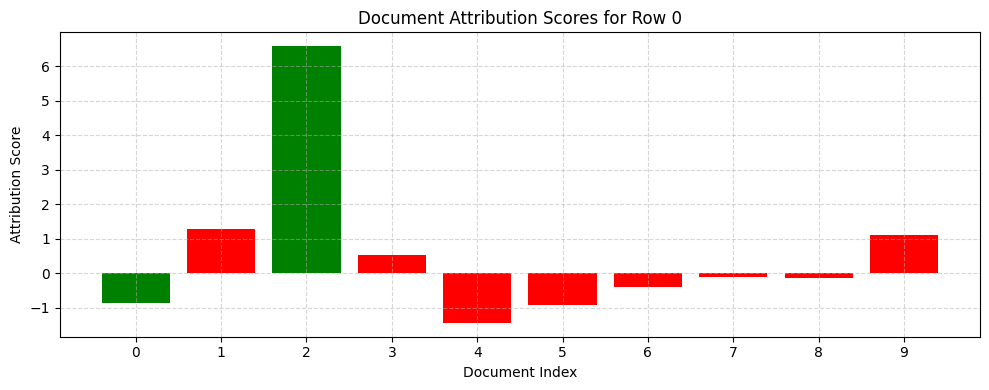

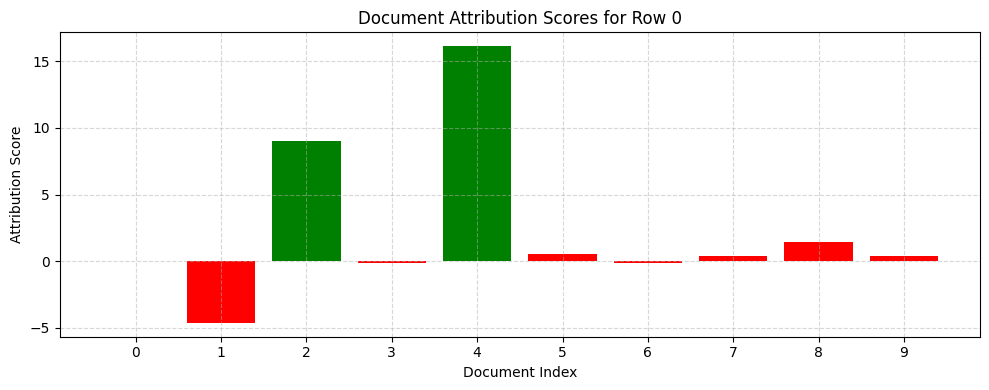

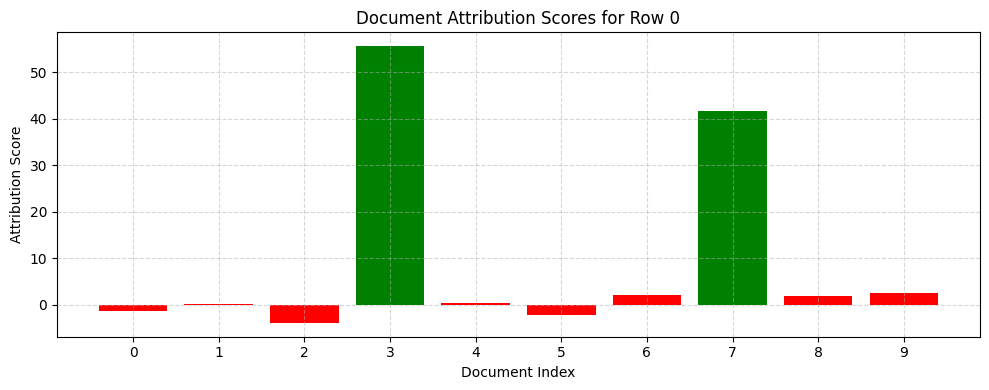

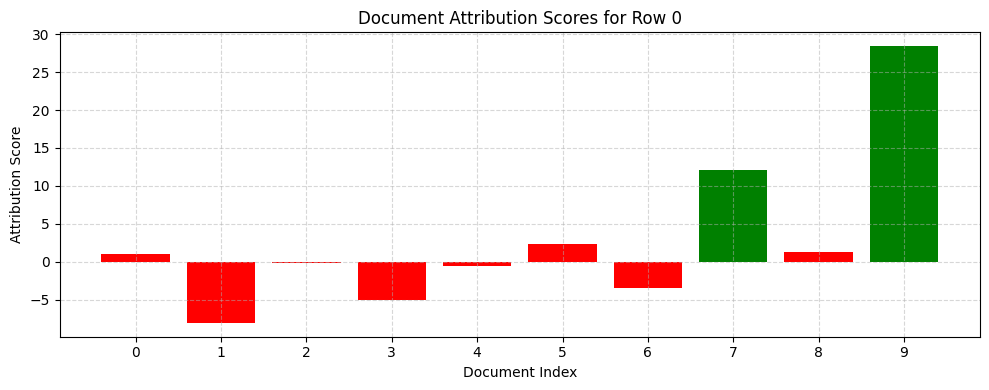

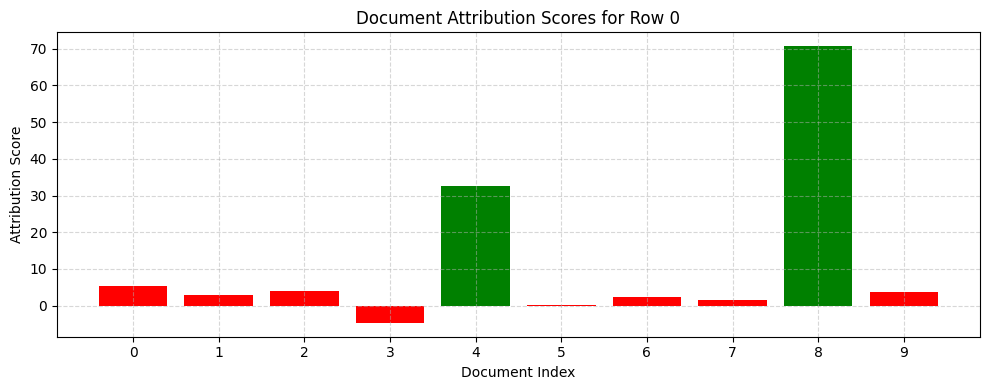

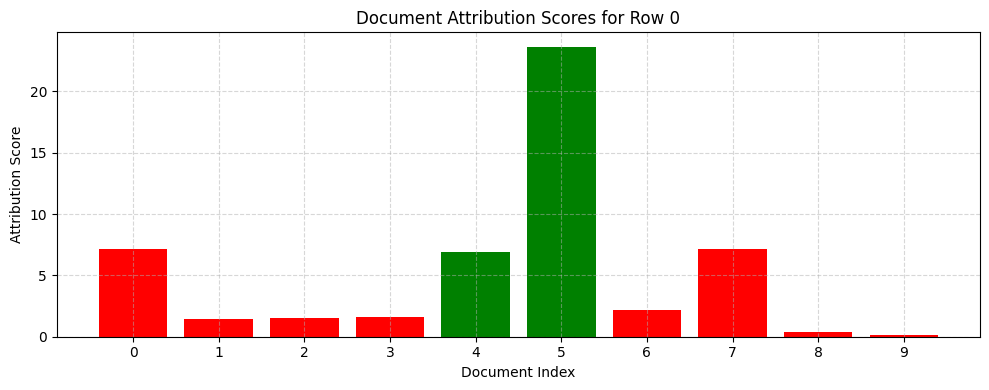

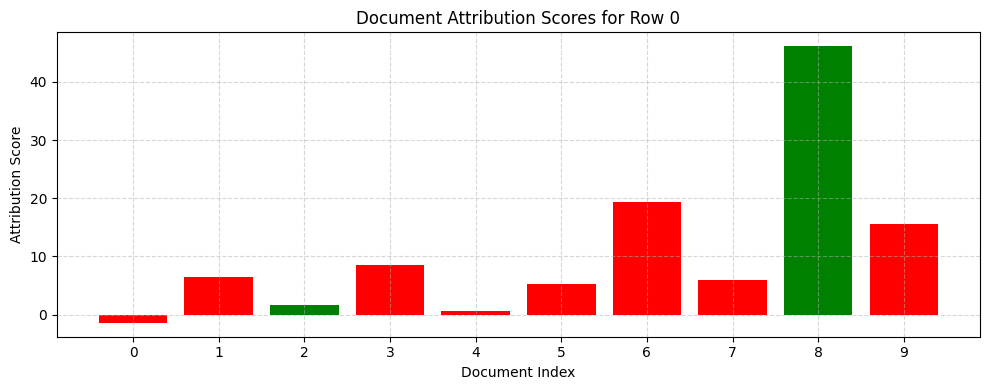

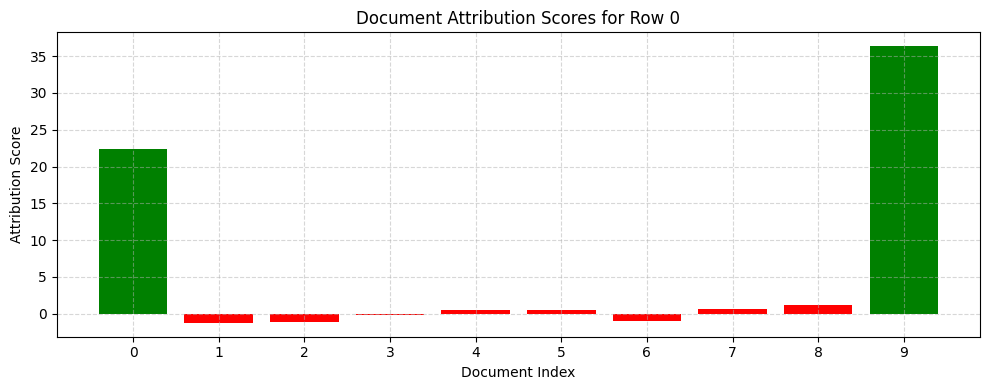

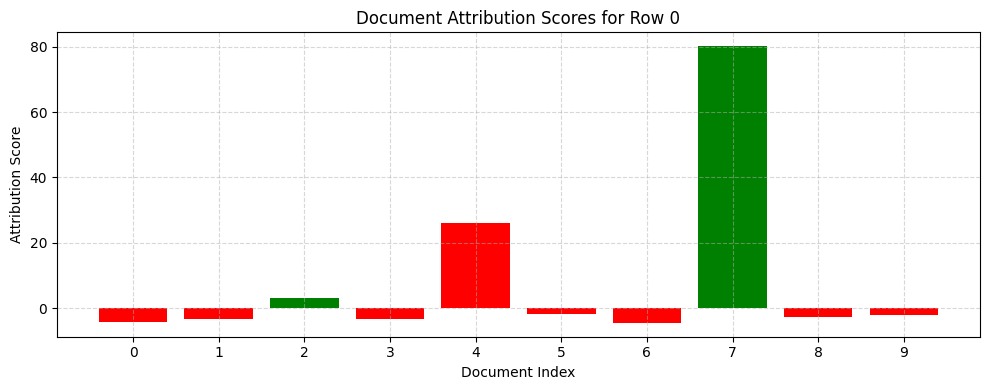

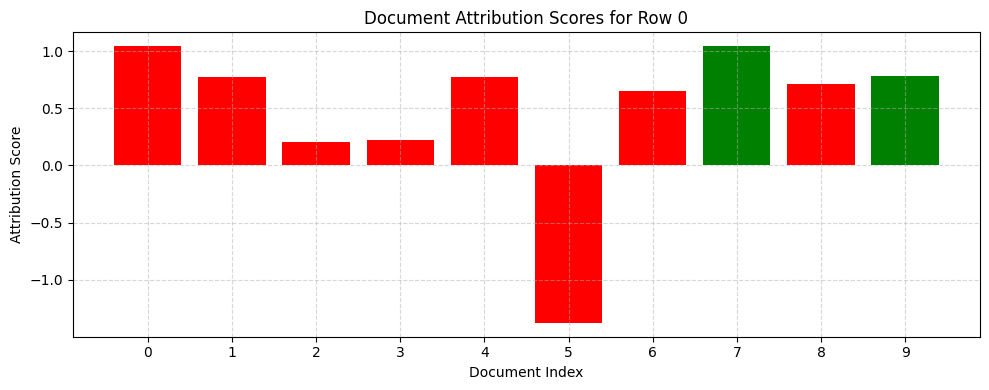

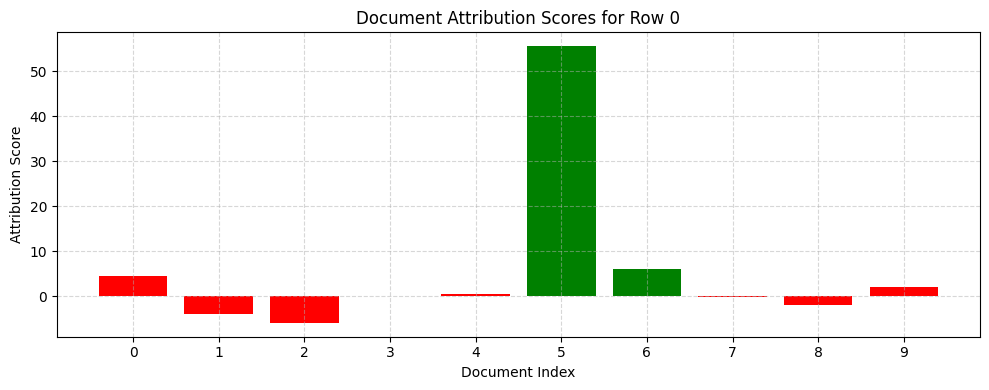

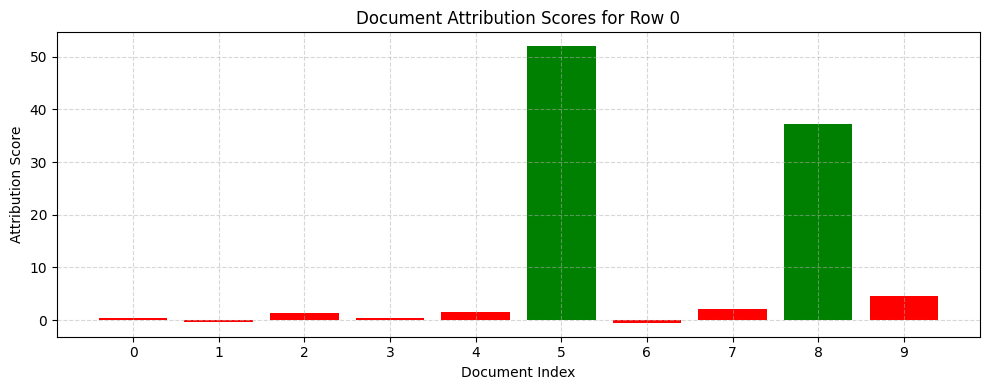

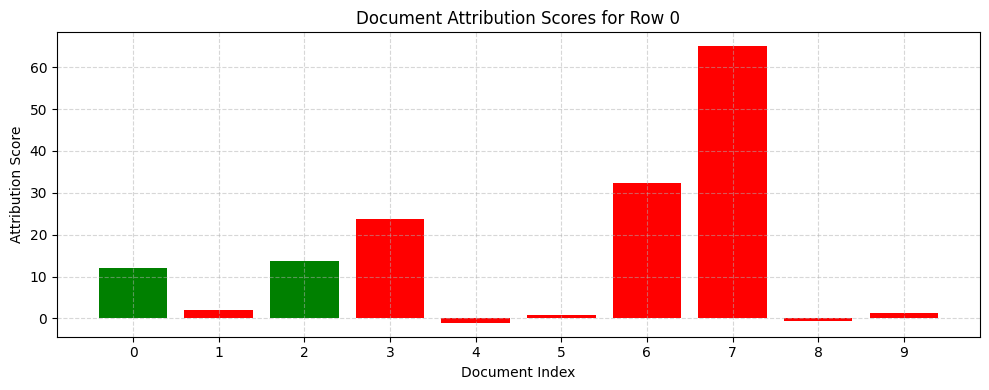

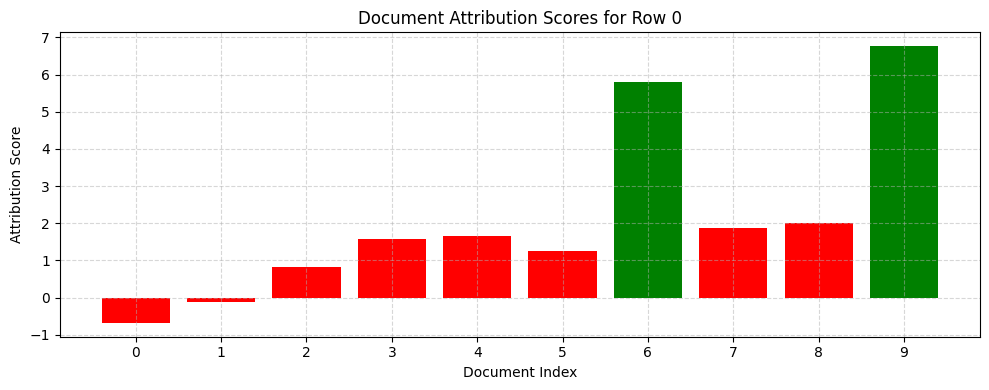

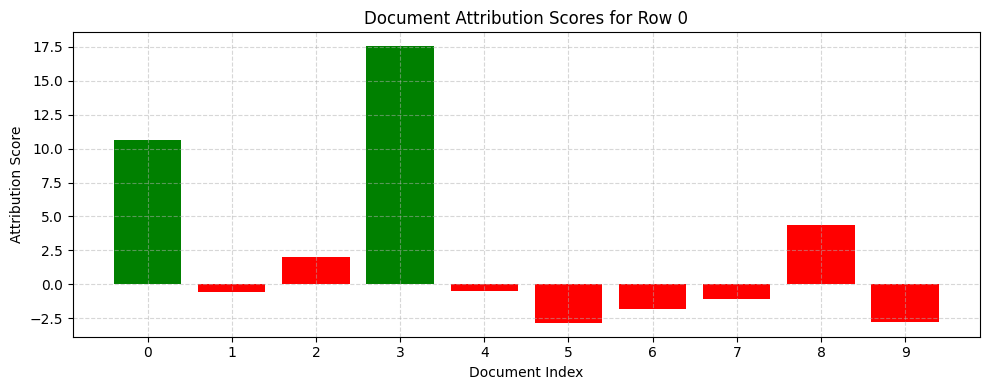

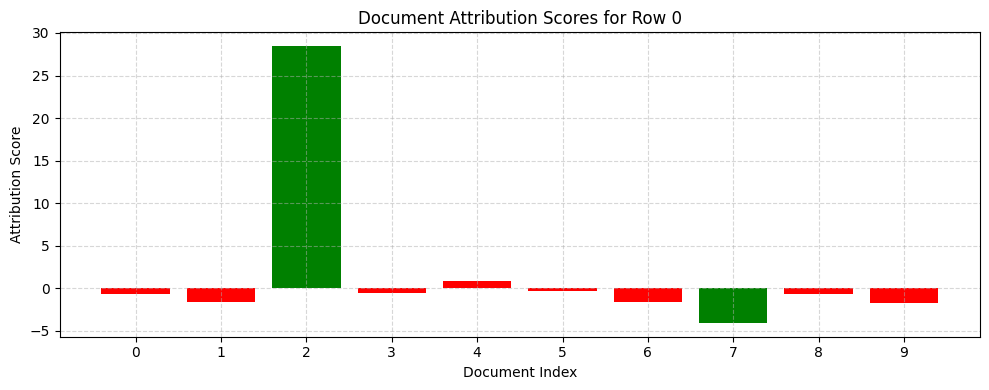

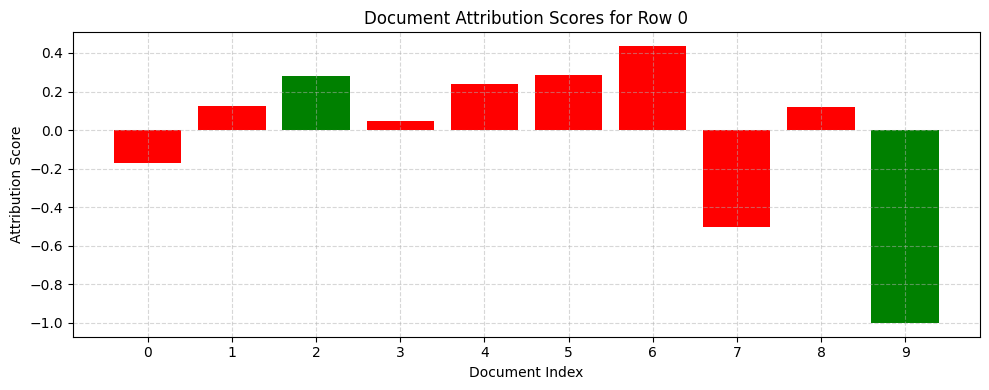

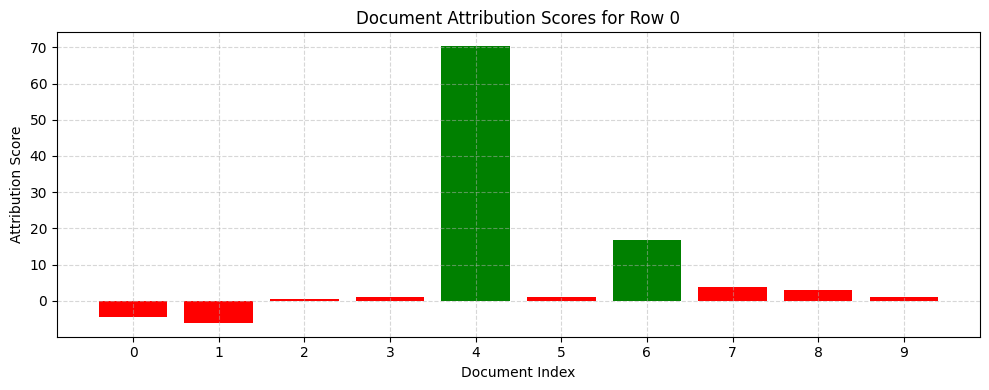

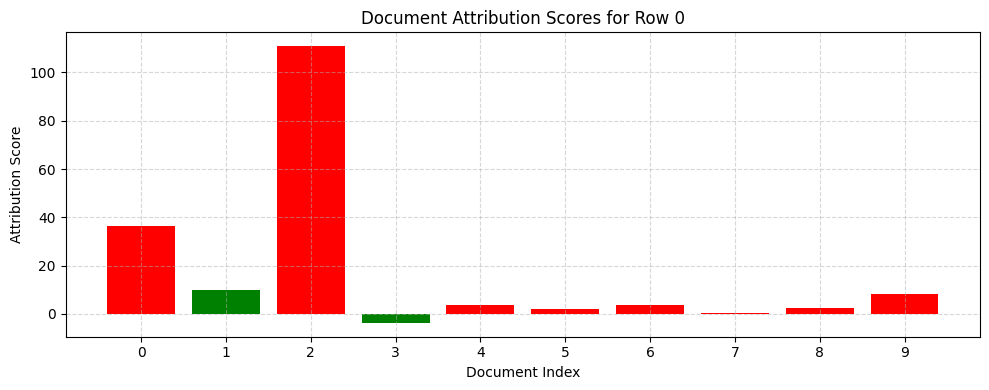

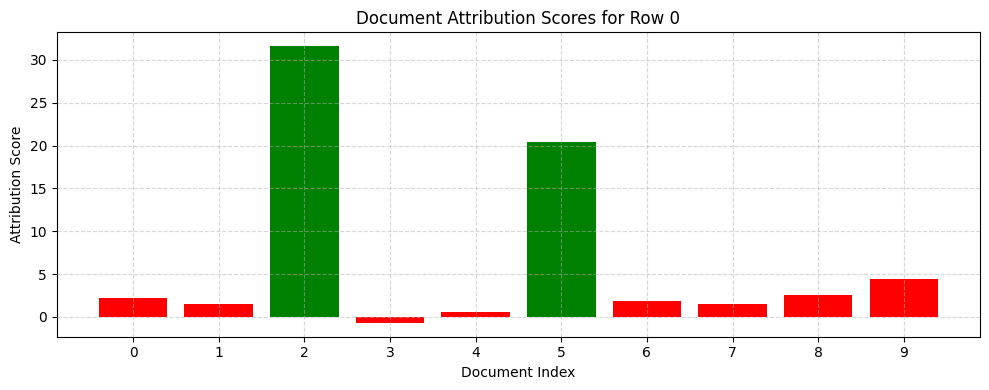

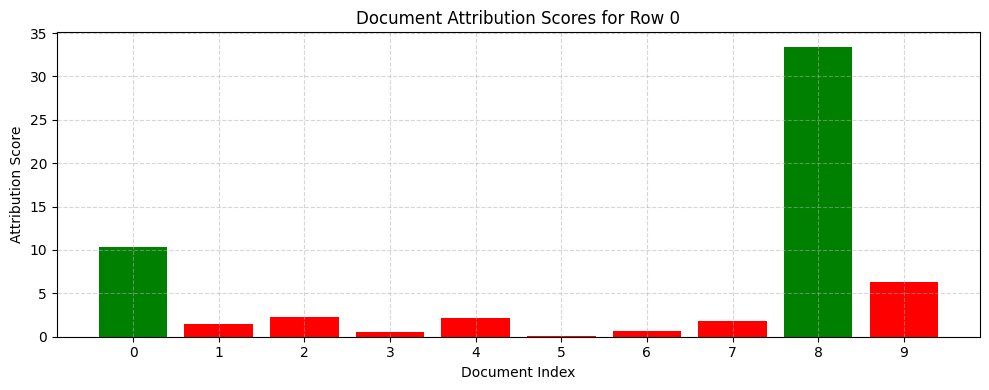

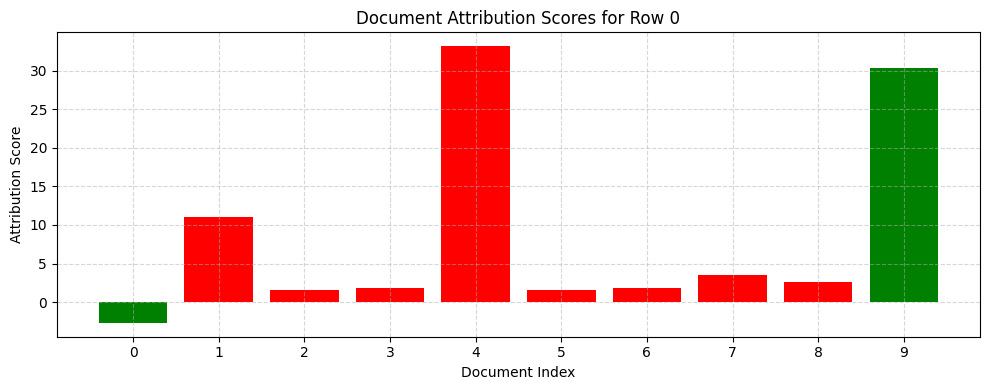

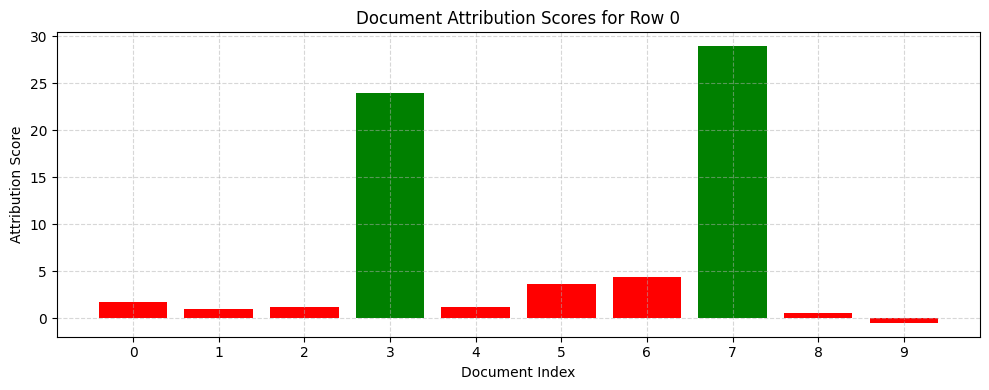

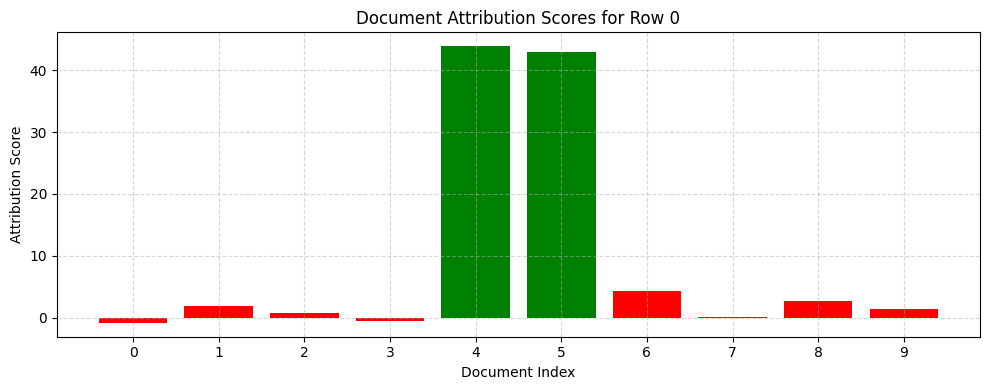

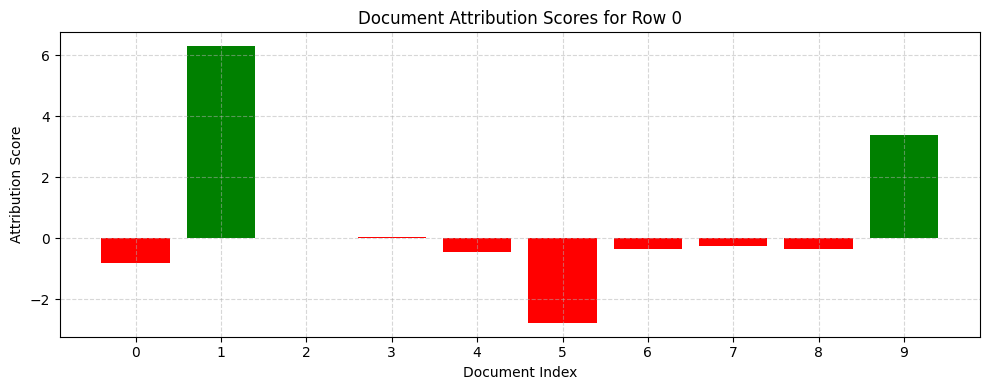

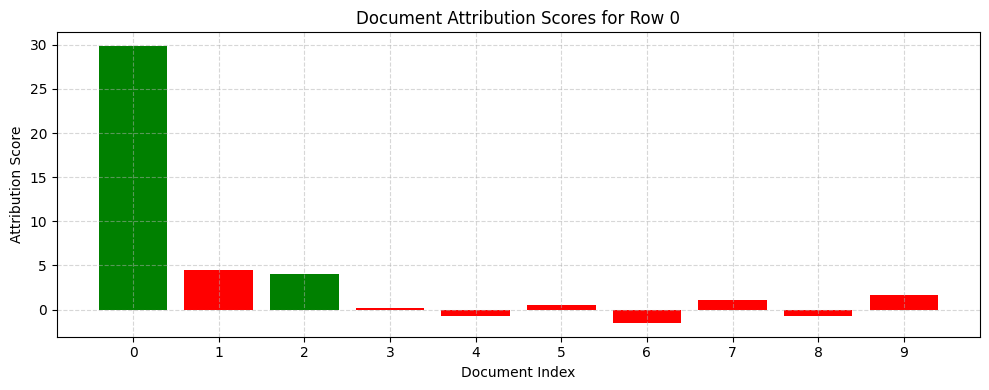

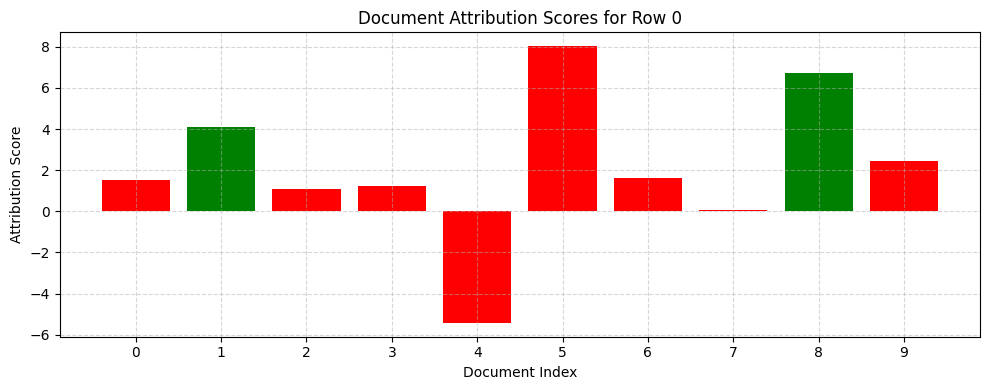

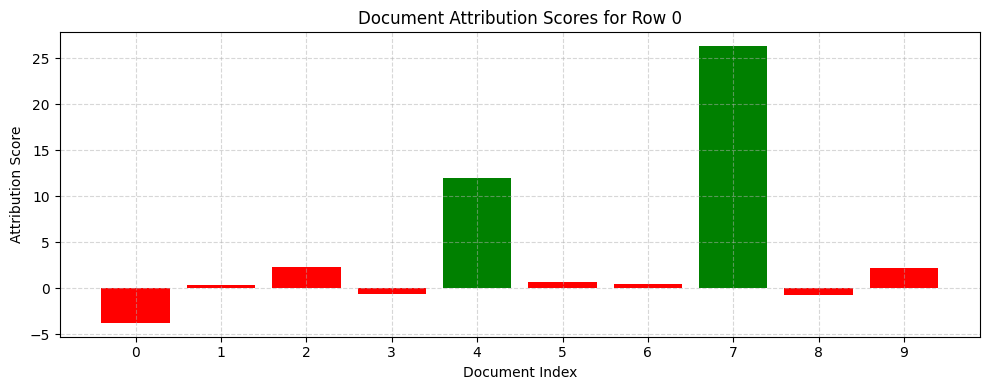

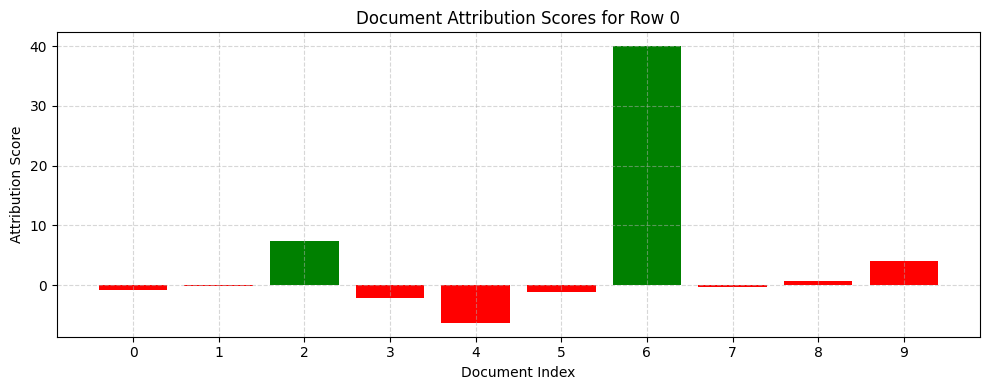

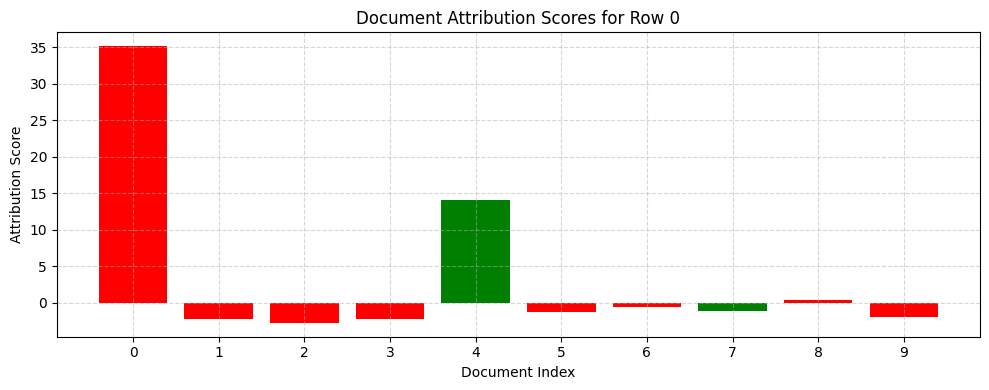

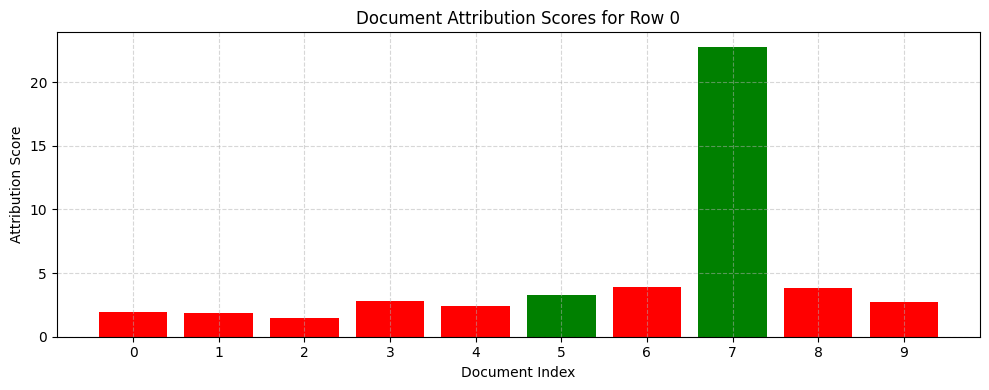

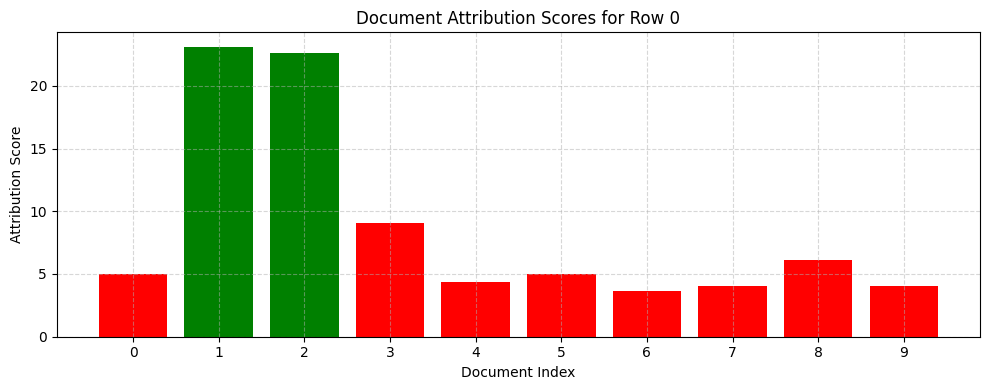

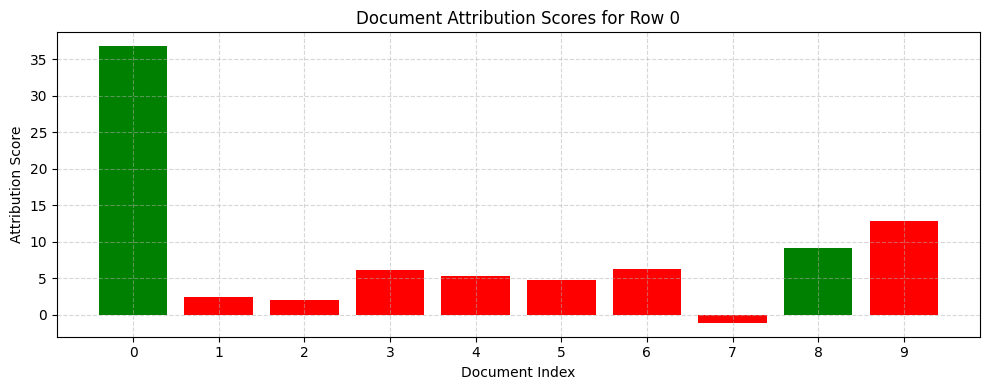

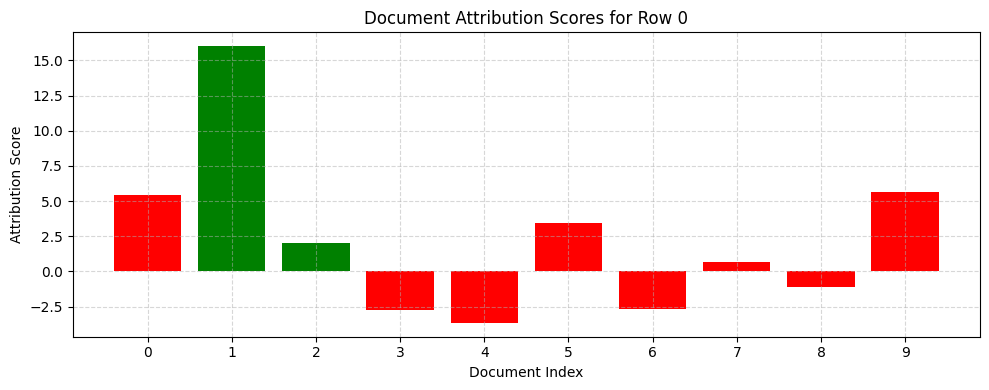

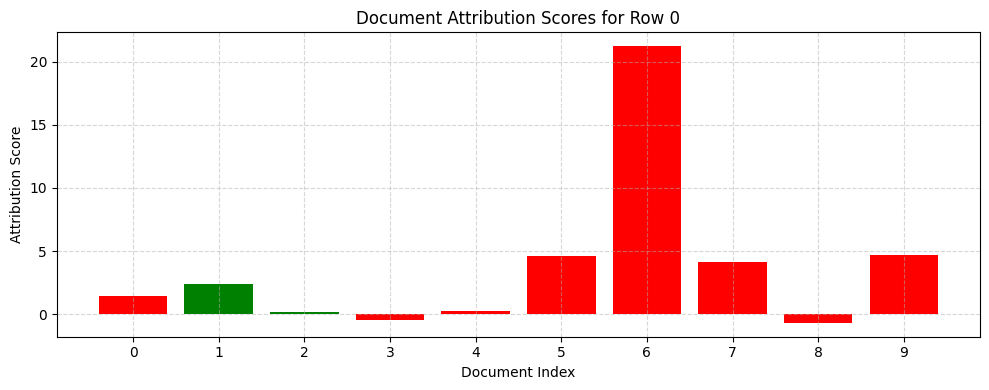

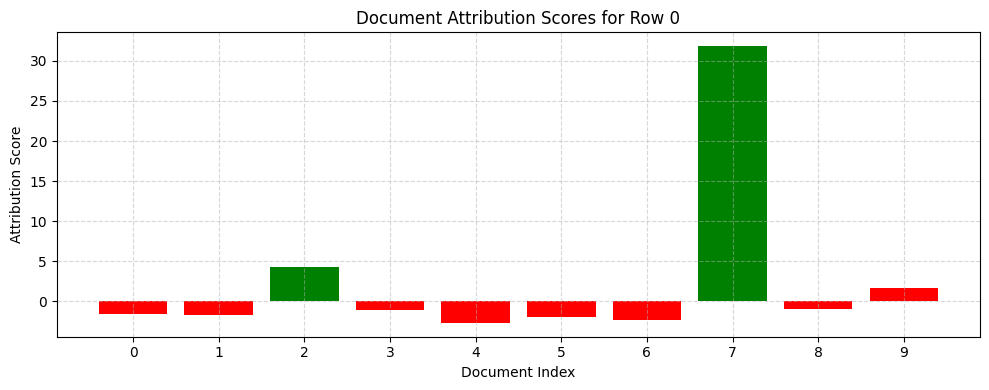

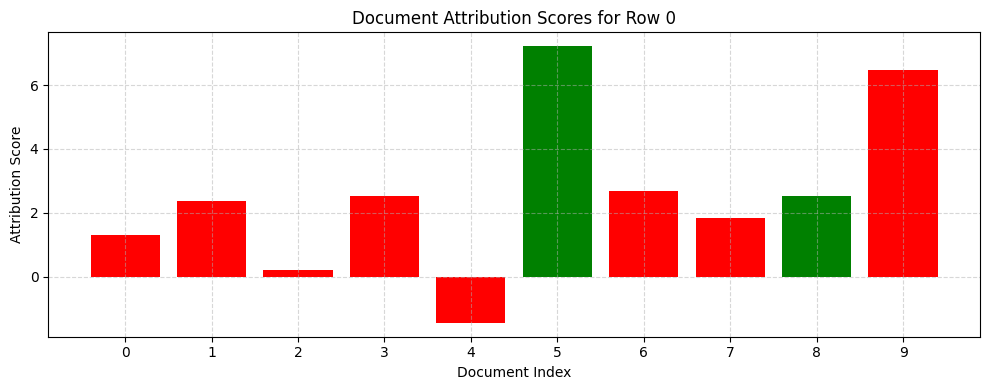

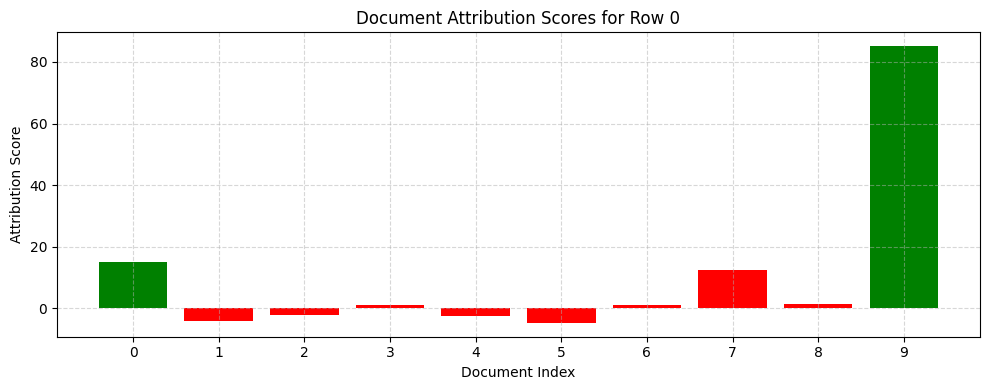

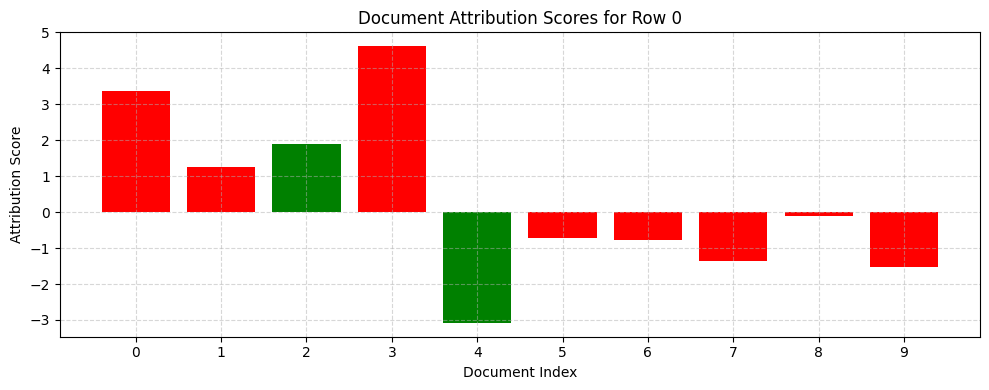

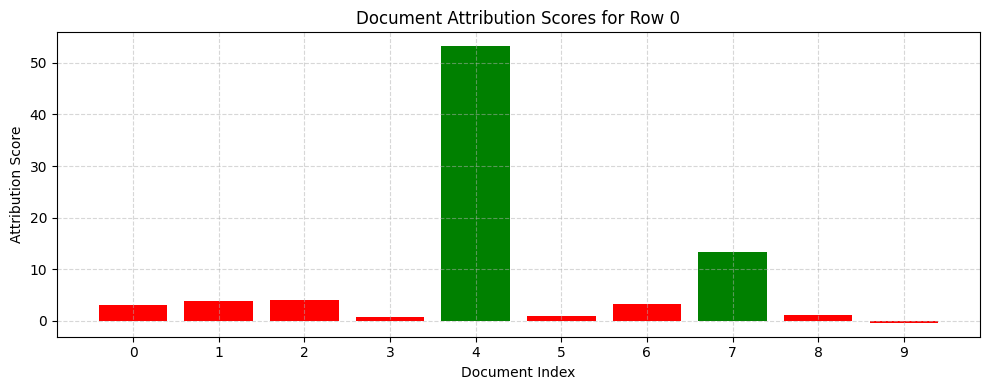

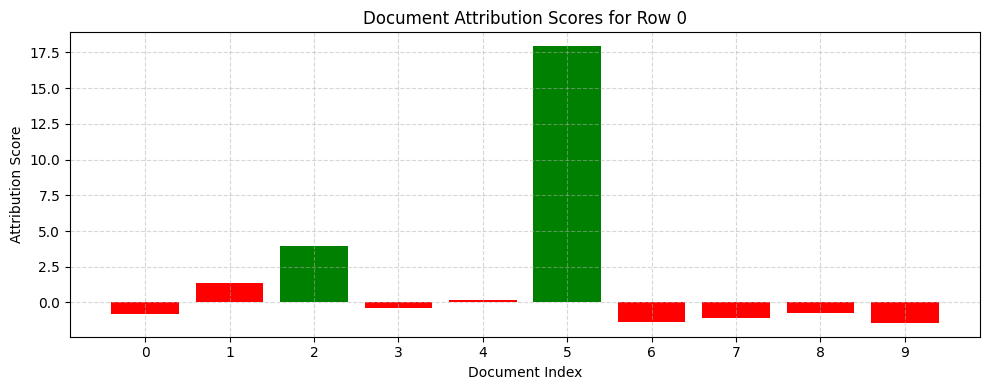

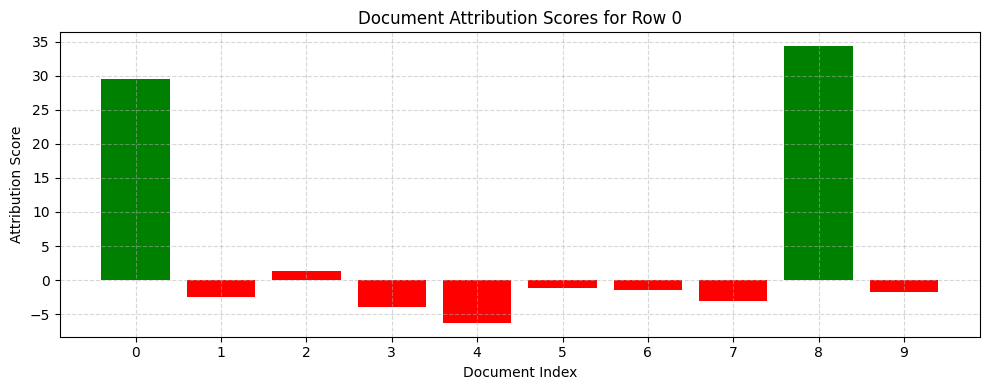

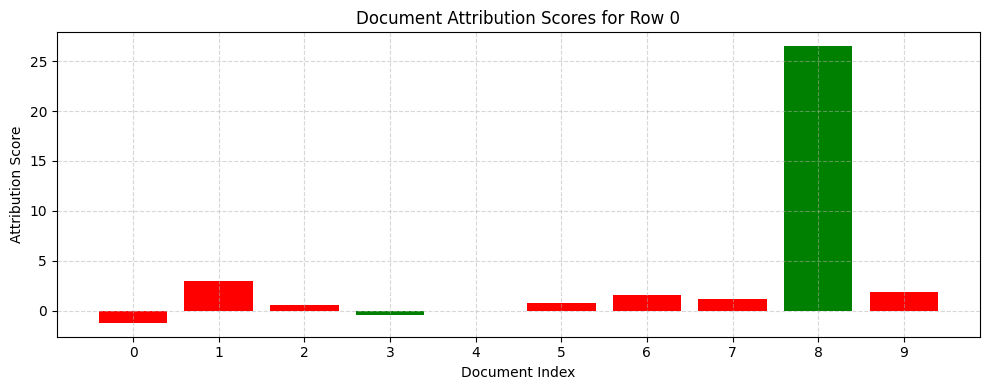

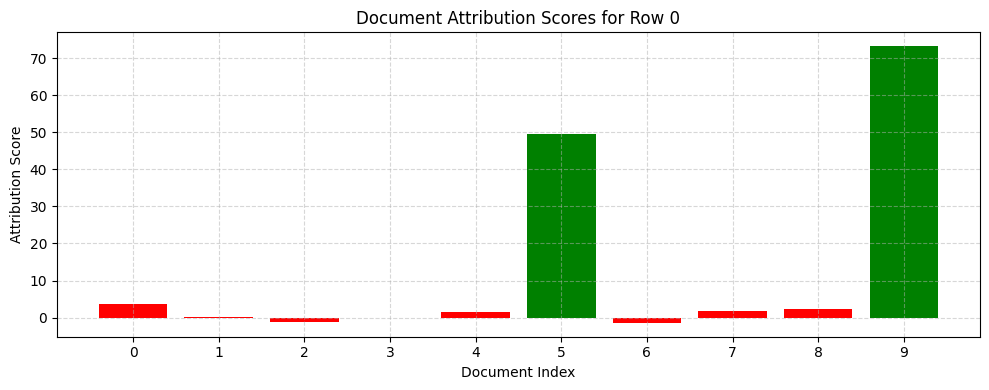

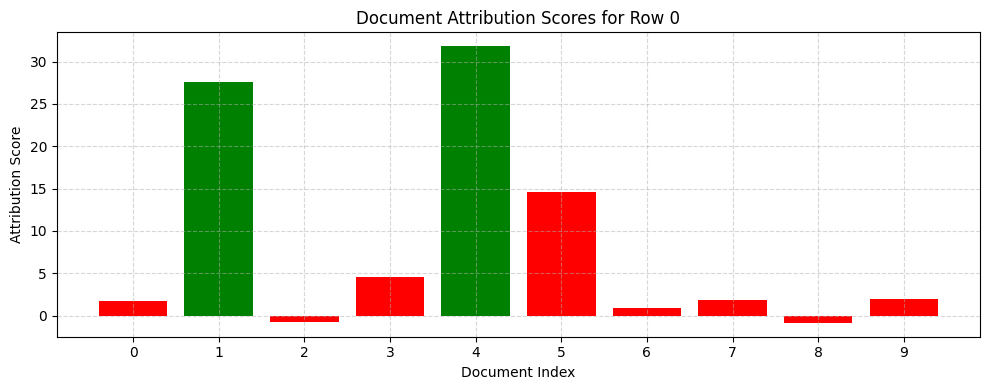

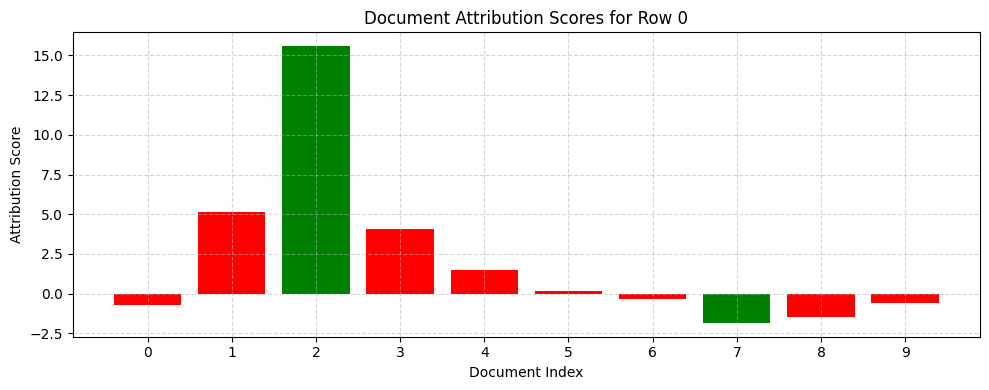

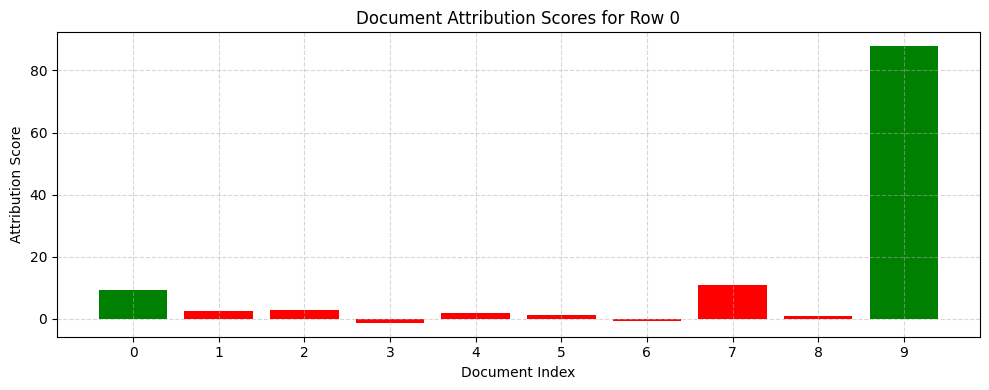

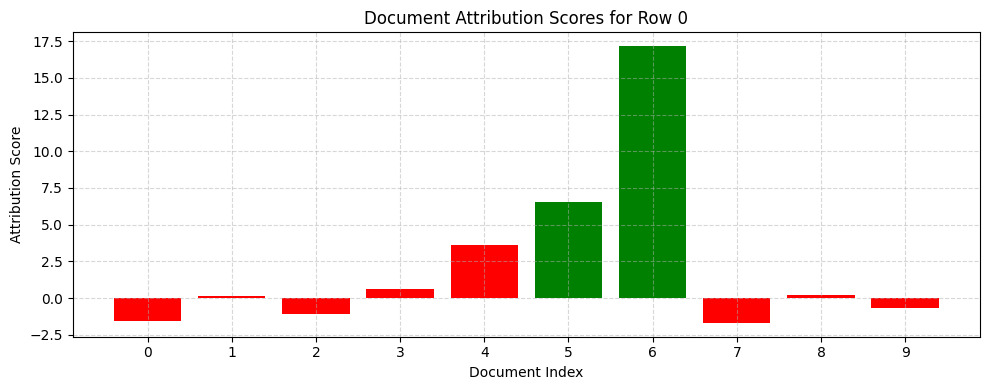

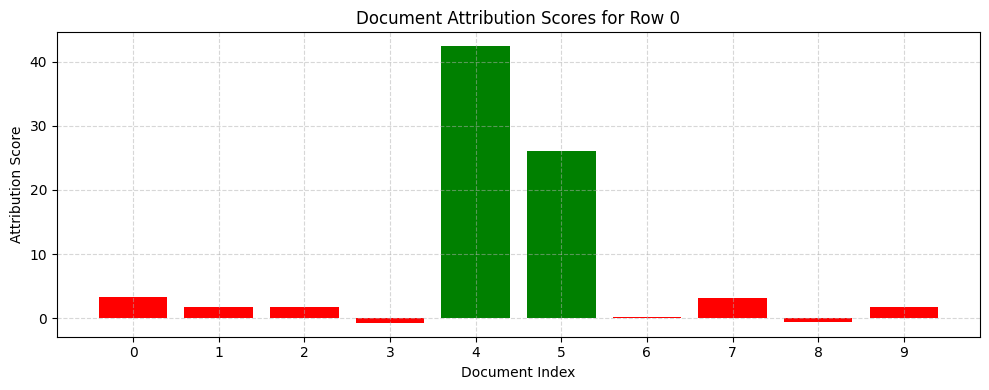

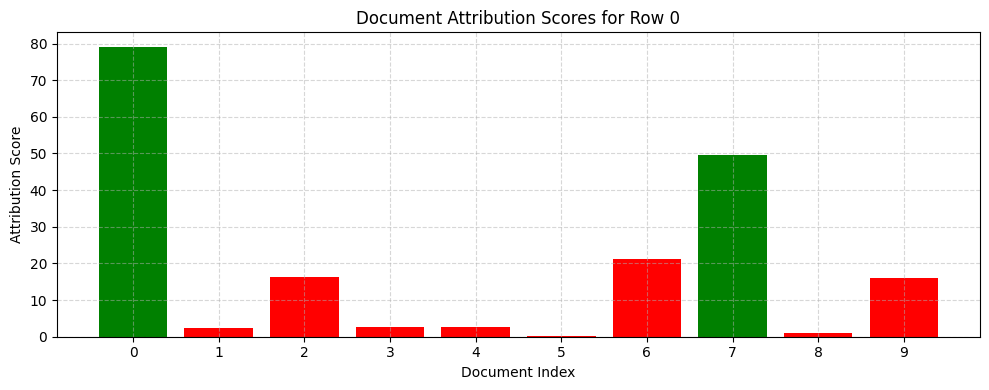

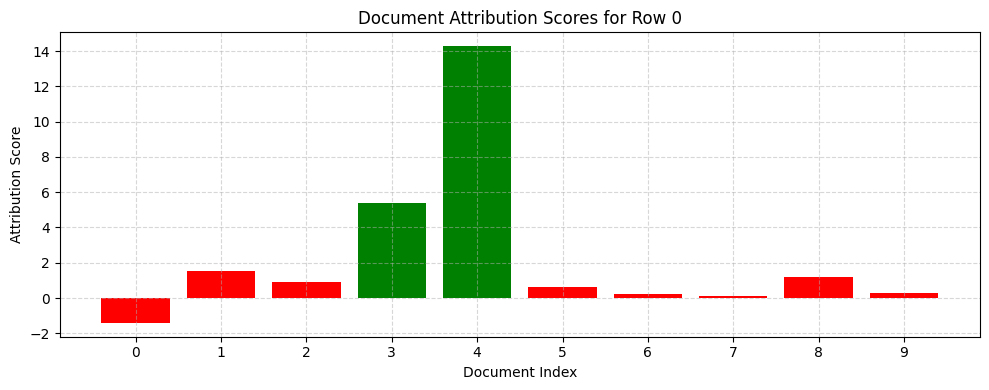

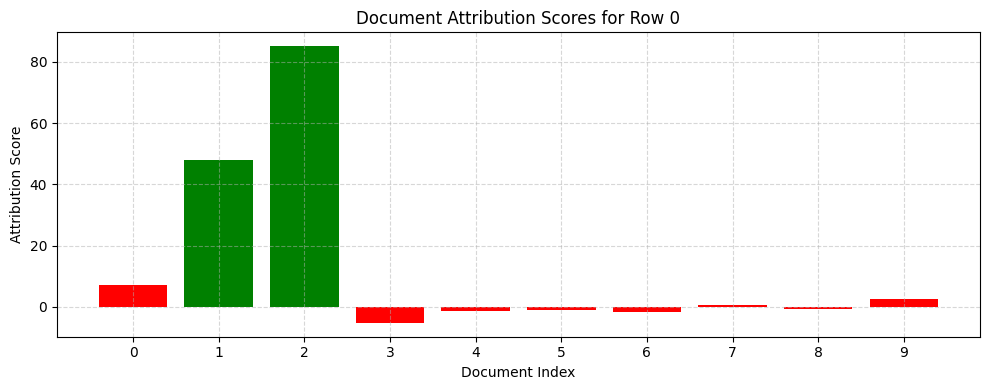

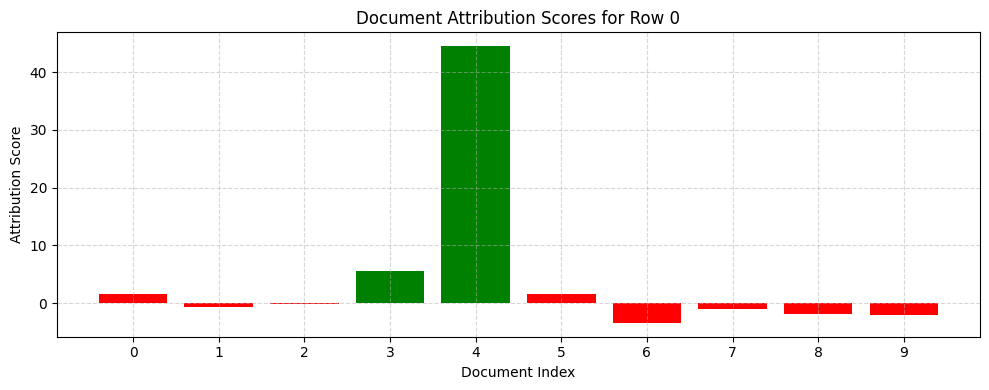

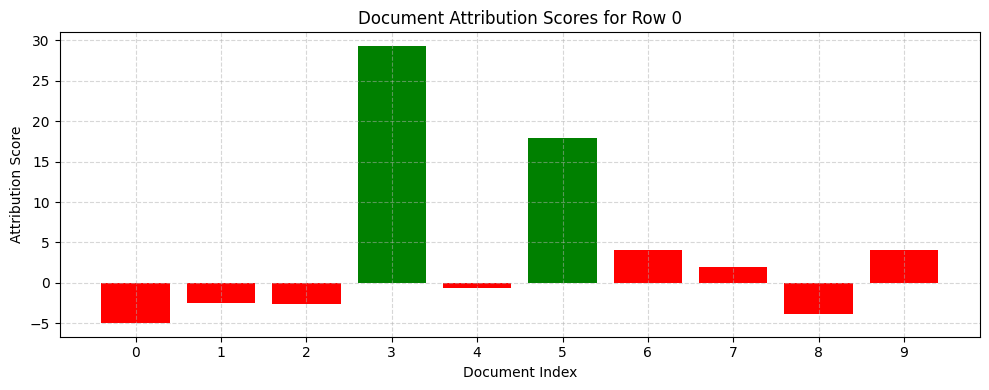

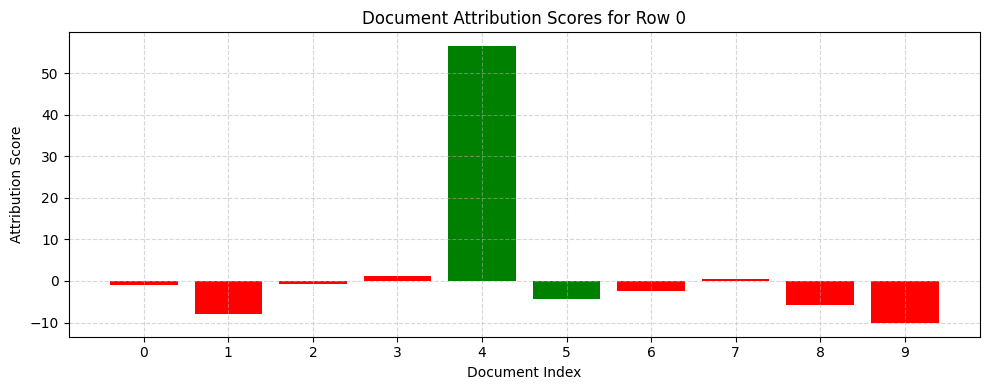

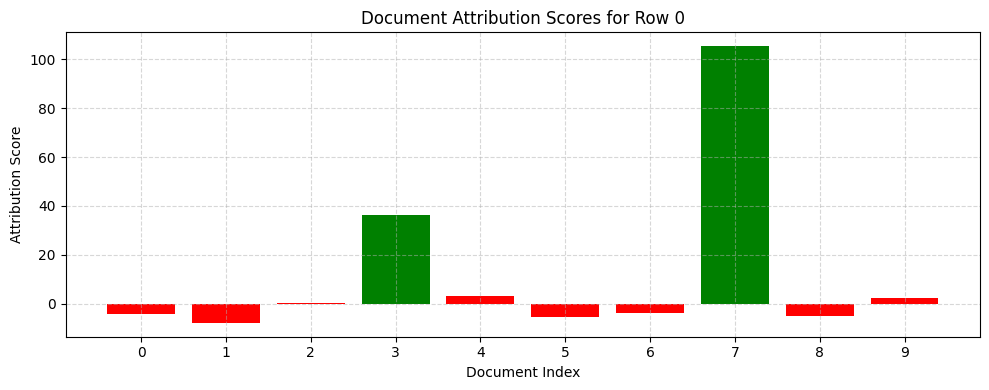

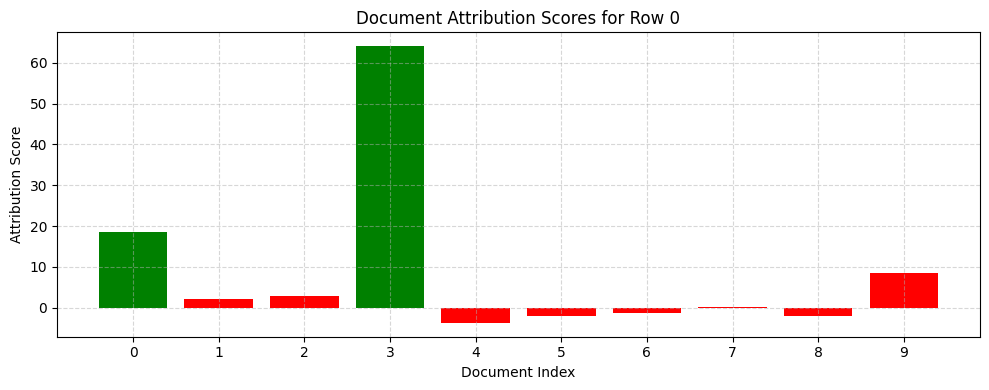

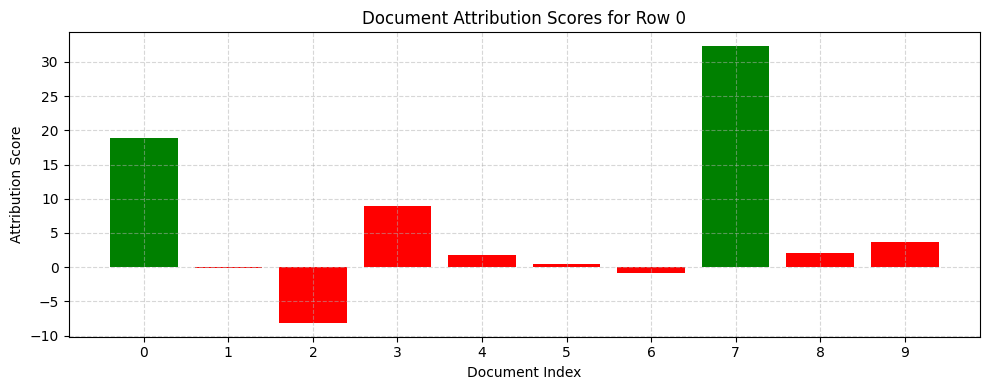

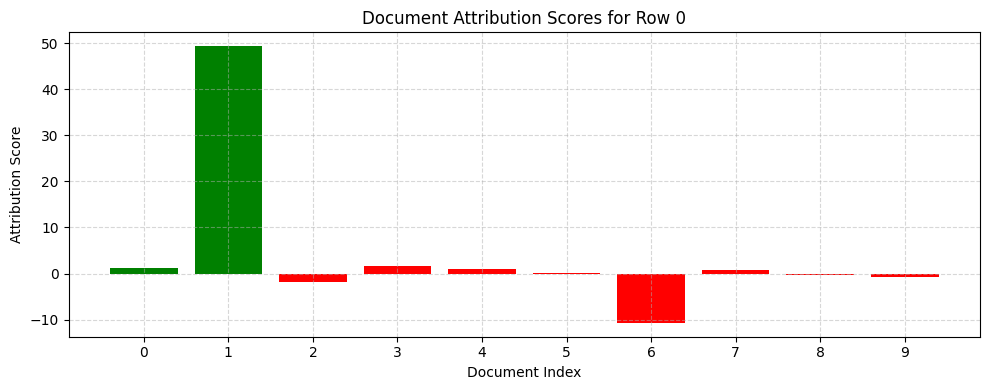

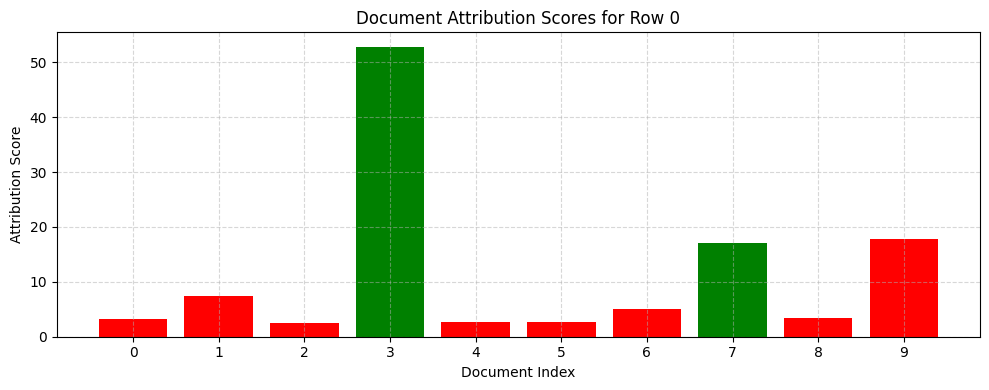

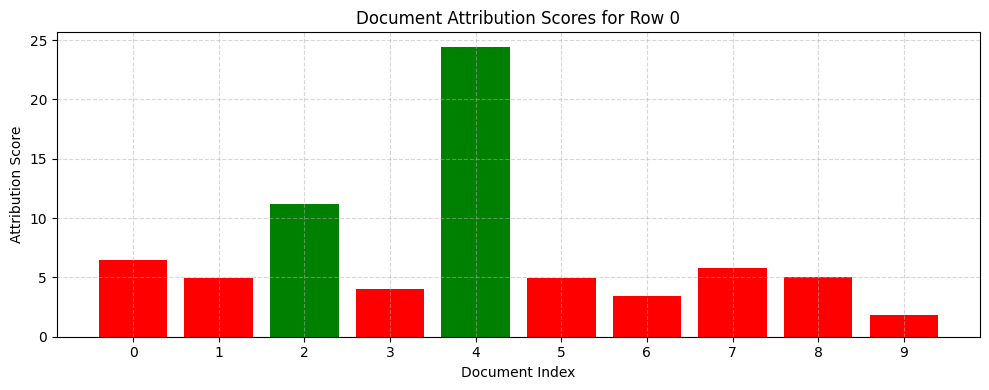

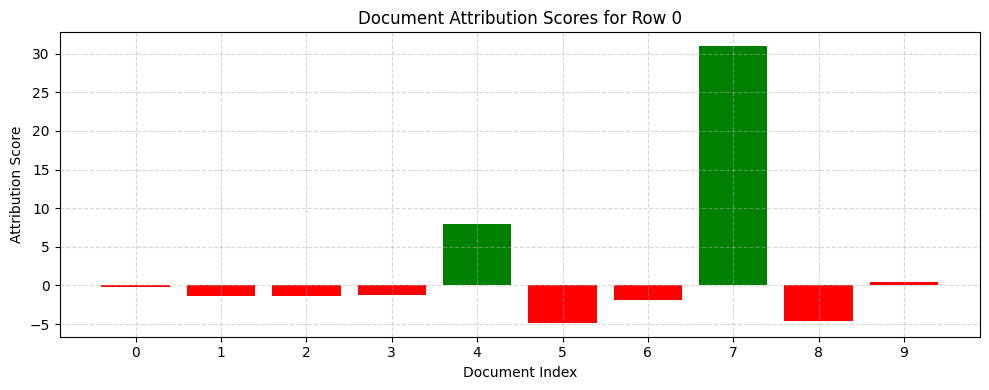

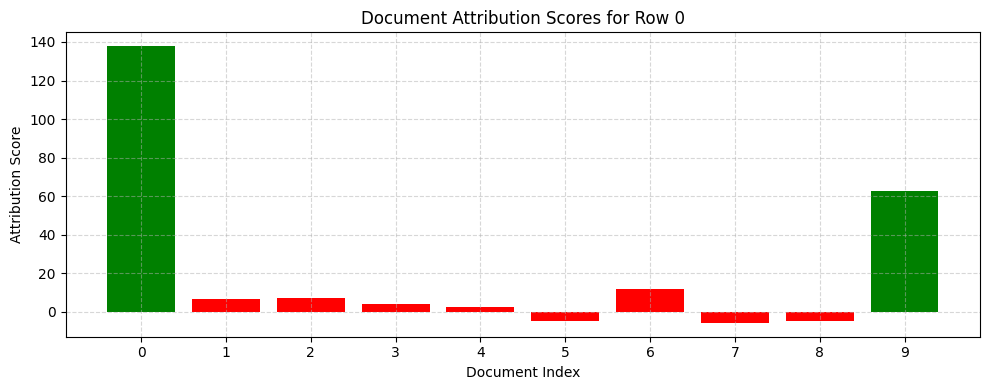

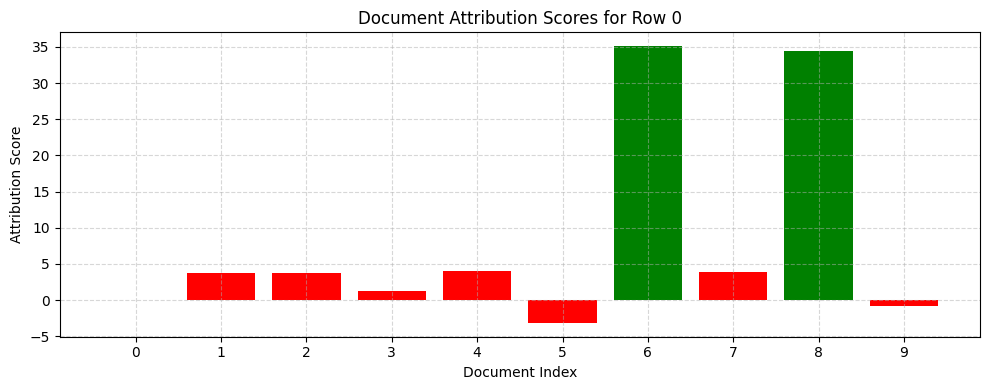

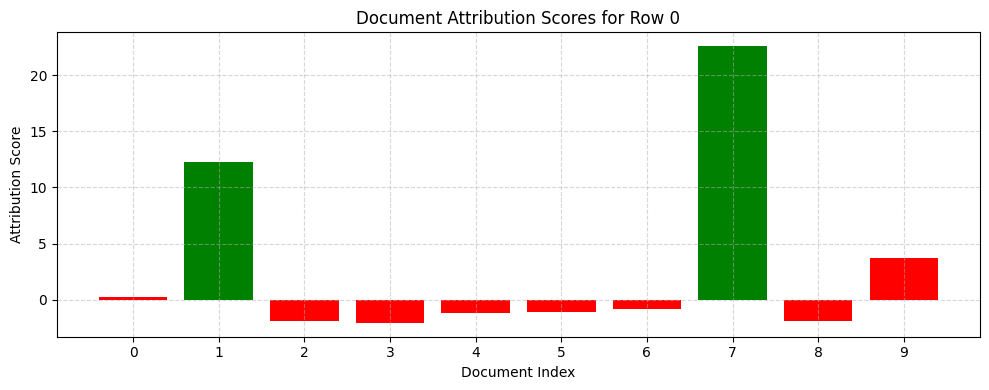

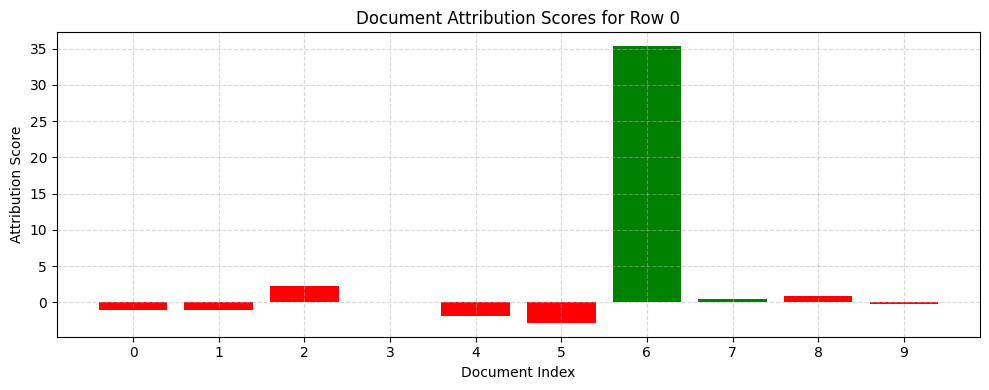

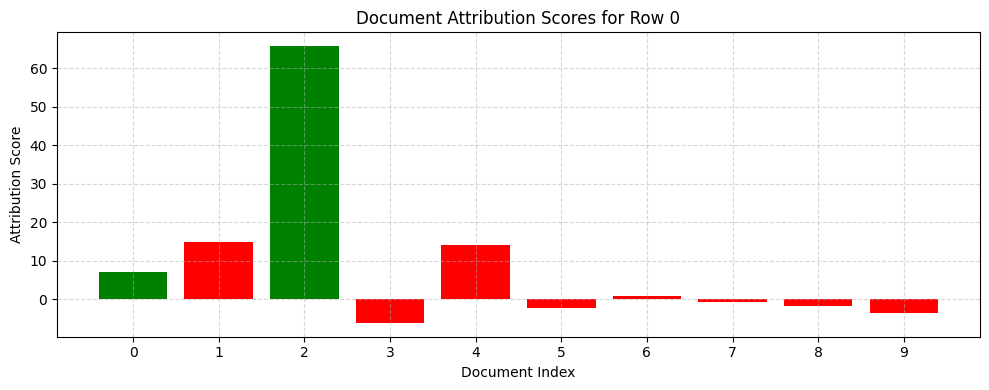

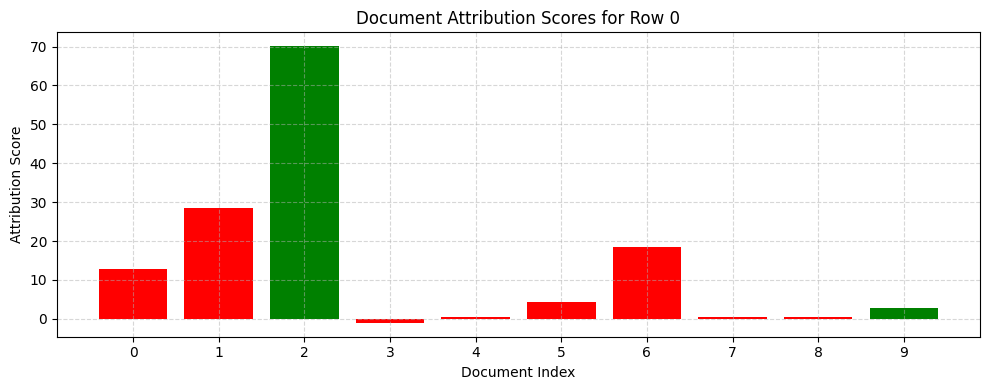

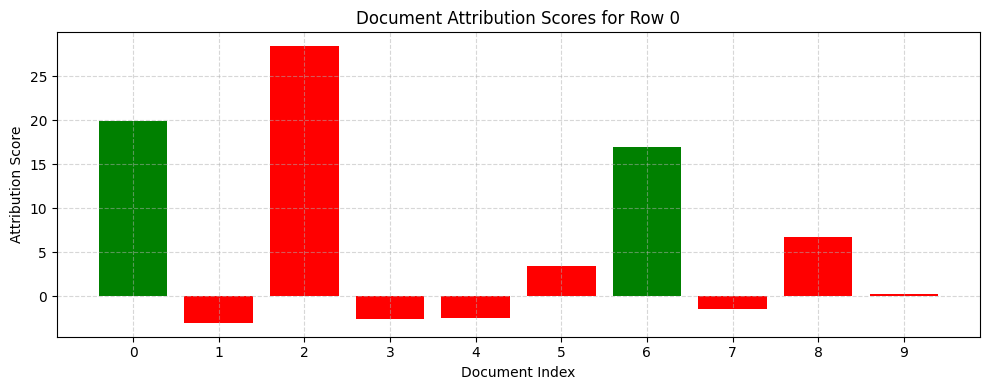

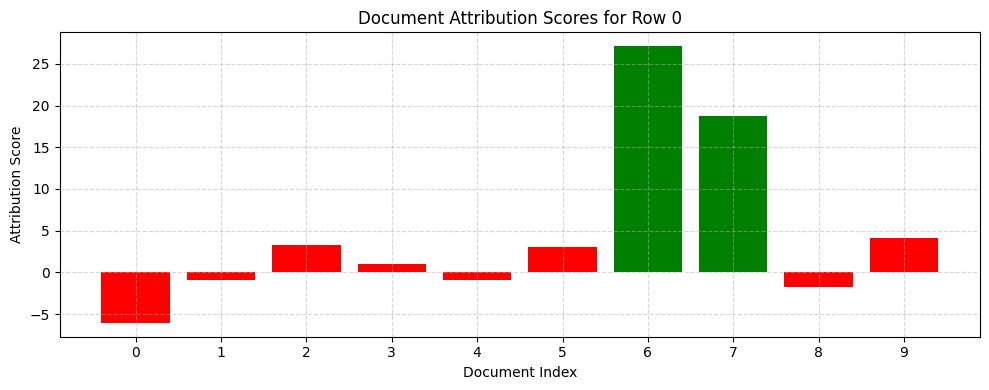

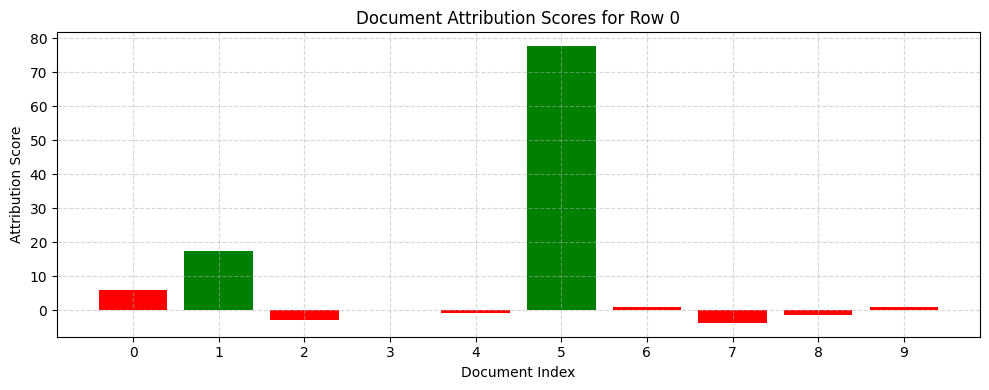

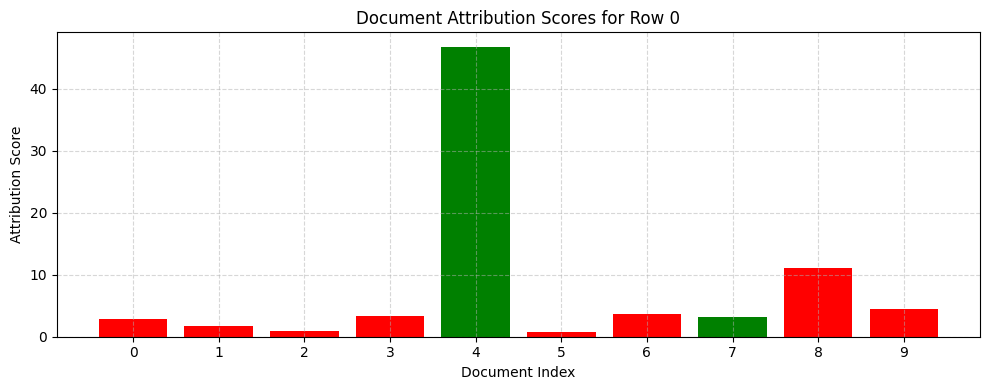

In [180]:
for i, row in df_plot[["scores", "doc_flags"]].iterrows():
    scores = row['scores']
    flags = row['doc_flags']
    
    # Color by flag: green if 'P', red if 'N'
    colors = ['green' if flag == 'P' else 'red' for flag in flags]
    
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(scores)), scores, color=colors)
    plt.title(f"Document Attribution Scores for Row {idx}")
    plt.xlabel("Document Index")
    plt.ylabel("Attribution Score")
    plt.xticks(range(len(scores)))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()